# Natural Language Processing Final Project

**Joana Rio Maior - 176189**

**Johanna Langemeyer - 175861**

**Maïwenn Mignon - 176196**


In this notebook, we implement a NLP project focused on New York Times articles section classification.

We begin by preparing and analyzing the dataset, then explore a range of models, from simpler approaches like logistic regression, to Naïve Bayes, a MLP and a fine-tune BERT. For each model we train two variants: a text-only baseline and a text + sentiment version that appends the four VADER scores (neg, neu, pos, compound) to every sample. A single stratified 70 / 15 / 15 split is reused for all experiments so the results are strictly comparable; we report accuracy, macro-F1 and confusion matrices to see where sentiment features help, hurt, or leave performance unchanged.

## Imports

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, log_loss
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader
!pip install transformers tensorflow jax

from transformers import (
    BertTokenizer, BertModel, AutoModelForSequenceClassification,
    BertPreTrainedModel, DataCollatorWithPadding,
    TrainingArguments, Trainer
)
from datasets import Dataset


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
import tqdm
!pip install spacy
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import BertTokenizer, DataCollatorWithPadding
from datasets import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from scipy.special import softmax
from tqdm import tqdm


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maiwe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maiwe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maiwe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\maiwe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maiwe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached jax-0.6.1-py3-none-any.whl.metadata (13 kB)
Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl (375.9 MB)
Using cached jax-0.6.1-py3-none-any.whl (2.4 MB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\maiwe\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\maiwe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
C:\Users\maiwe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not fo

In [ ]:
df = pd.read_csv(r"C:\Users\maiwe\OneDrive\Documents\Uni\Natural Language Processing & Text Analytics\Final Project\archive (5)\nyt-metadata.csv")


C:\Users\maiwe\AppData\Local\Temp\ipykernel_46888\1840826379.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\maiwe\OneDrive\Documents\Uni\Natural Language Processing & Text Analytics\Final Project\archive (5)\nyt-metadata.csv")


## Exploratory Data Analyis

In [ ]:
df.head()

,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,headline,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri,subsection_name
0,Article on upcoming New York Giants-Dallas Cow...,https://www.nytimes.com/2000/01/01/sports/pro-...,Article on upcoming New York Giants-Dallas Cow...,Waiting in the visiting locker room at Texas S...,D,2.0,The New York Times,[],"{'main': 'Playoffs or No, Dallas Provides The ...","[{'name': 'organizations', 'value': 'New York ...",2000-01-01 05:00:00+00:00,article,Sports Desk,Sports,"{'original': 'By Bill Pennington', 'person': [...",News,nyt://article/01111a48-3502-5021-8096-bc929379...,819.0,nyt://article/01111a48-3502-5021-8096-bc929379...,NaN
1,Jeanne C Pond letter expresses hope that spiri...,https://www.nytimes.com/2000/01/01/opinion/l-o...,Jeanne C Pond letter expresses hope that spiri...,To the Editor:,A,30.0,The New York Times,[],"{'main': 'On This First Day, a Fanfare for the...","[{'name': 'persons', 'value': 'Pond, Jeanne C'...",2000-01-01 05:00:00+00:00,article,Editorial Desk,Opinion,"{'original': '', 'person': [], 'organization':...",Letter,nyt://article/02328edc-dad1-5eb0-900e-917162e4...,122.0,nyt://article/02328edc-dad1-5eb0-900e-917162e4...,NaN
2,Many experts on Y2K computer problem report th...,https://www.nytimes.com/2000/01/01/us/1-1-00-t...,Many experts on Y2K computer problem report th...,As the world slid nervously yesterday through ...,A,10.0,The New York Times,[],"{'main': ""Internet's Cheering Squad Nervously ...","[{'name': 'subject', 'value': 'Electronic Mail...",2000-01-01 05:00:00+00:00,article,National Desk,U.S.,"{'original': 'By Barnaby J. Feder', 'person': ...",News,nyt://article/02a8f89b-153f-5b84-983c-e328de5b...,761.0,nyt://article/02a8f89b-153f-5b84-983c-e328de5b...,NaN
3,WILL the forces of globalism continue to push ...,https://www.nytimes.com/2000/01/01/news/vision...,NaN,WILL the forces of globalism continue to push ...,E,4.0,The New York Times,[],{'main': 'Economic Thinking Finds a Free Marke...,[],2000-01-01 05:00:00+00:00,article,The Millennium,Archives,"{'original': 'By Floyd Norris', 'person': [{'f...",News,nyt://article/0634d837-97b8-59b5-aa17-f90d1a89...,916.0,nyt://article/0634d837-97b8-59b5-aa17-f90d1a89...,NaN
4,SPECIAL TODAY The Millennium Envisioning th...,https://www.nytimes.com/2000/01/01/nyregion/in...,NaN,SPECIAL TODAY,A,1.0,The New York Times,[],"{'main': 'INSIDE', 'kicker': None, 'content_ki...",[],2000-01-01 05:00:00+00:00,article,Metropolitan Desk,New York,"{'original': '', 'person': [], 'organization':...",Summary,nyt://article/0654cc64-c37f-594d-9290-1ce578cd...,102.0,nyt://article/0654cc64-c37f-594d-9290-1ce578cd...,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191681 entries, 0 to 2191680
Data columns (total 20 columns):
 #   Column            Dtype  
---  ------            -----  
 0   abstract          object 
 1   web_url           object 
 2   snippet           object 
 3   lead_paragraph    object 
 4   print_section     object 
 5   print_page        object 
 6   source            object 
 7   multimedia        object 
 8   headline          object 
 9   keywords          object 
 10  pub_date          object 
 11  document_type     object 
 12  news_desk         object 
 13  section_name      object 
 14  byline            object 
 15  type_of_material  object 
 16  _id               object 
 17  word_count        float64
 18  uri               object 
 19  subsection_name   object 
dtypes: float64(1), object(19)
memory usage: 334.4+ MB


In [ ]:
df.describe()

,word_count
count,2.191679e+06
mean,6.639831e+02
std,7.120655e+02
min,0.000000e+00
25%,1.890000e+02
50%,5.510000e+02
75%,9.550000e+02
max,1.024390e+05


### Preliminary feature selection

In [ ]:
cols_to_drop = [
    "web_url",
    "snippet",
    "print_section",
    "print_page",
    "source",
    "multimedia",
    "news_desk",
    "byline",
    "_id",
    "uri",
    "subsection_name"
]

df.drop(columns=cols_to_drop, inplace=True)
print("Remaining columns:", df.columns.tolist())


Remaining columns: ['abstract', 'lead_paragraph', 'headline', 'keywords', 'pub_date', 'document_type', 'section_name', 'type_of_material', 'word_count']


### Missing values

In [ ]:
null_percentages = (df.isnull().sum() / len(df)) * 100
null_percentages = null_percentages.round(2).astype(str) + "%"
null_percentages

abstract            1.46%
lead_paragraph      1.92%
headline             0.0%
keywords             0.0%
pub_date             0.0%
document_type        0.0%
section_name        0.09%
type_of_material    3.89%
word_count           0.0%
dtype: object

In [ ]:
# Drop all rows with NaNs in any column
df.dropna(inplace=True)

null_percentages = (df.isnull().sum() / len(df) * 100).round(2).astype(str) + "%"
print(null_percentages)


abstract            0.0%
lead_paragraph      0.0%
headline            0.0%
keywords            0.0%
pub_date            0.0%
document_type       0.0%
section_name        0.0%
type_of_material    0.0%
word_count          0.0%
dtype: object


### Duplicates

In [ ]:
# We check if the dataset contains duplicates, and then drop them
num_dupes = df.duplicated().sum()
print(f"Total duplicate rows: {num_dupes}")


dupes = df[df.duplicated()]
print(dupes.head())


Total duplicate rows: 1908
                                                abstract  \
17934  Barbara Corcoran, founder of the Corcoran Grou...   
34230  Because of an editing error, an article yester...   
48322   HOCKEY    National Hockey League  COLORADO AV...   
55554  Two picture credits with the cover article on ...   
66316  KATZ-Florence M. Beloved wife of Jerome. Cheri...   

                                          lead_paragraph  \
17934  THE big-city realtor, Barbara Corcoran, 50, fo...   
34230  Because of an editing error, an article yester...   
48322                                             HOCKEY   
55554  Two picture credits with the cover article on ...   
66316  KATZ-Florence M. Beloved wife of Jerome. Cheri...   

                                                headline  \
17934  {'main': 'What Do You Do All Day?', 'kicker': ...   
34230  {'main': 'Corrections', 'kicker': None, 'conte...   
48322  {'main': 'TRANSACTIONS', 'kicker': None, 'cont...   
55554  {'ma

In [ ]:
df.drop_duplicates(keep="first", inplace=True)

In [ ]:
df.shape

(2062191, 9)

### Time Split

In [ ]:
# We ensure date is in the appropriate format
df['pub_date'] = pd.to_datetime(df['pub_date'], errors='coerce')

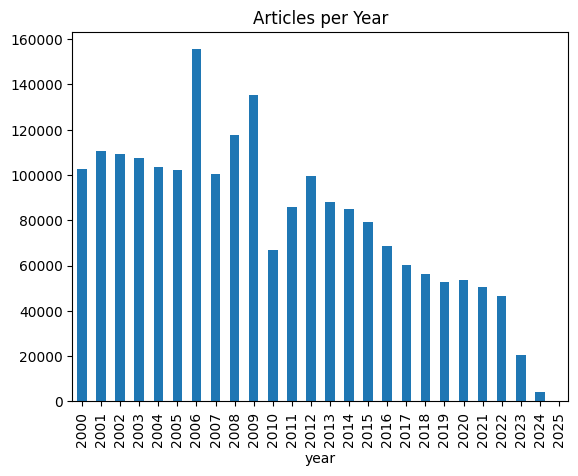

In [ ]:
df['year'] = df['pub_date'].dt.year
df['month'] = df['pub_date'].dt.month

# Articles per year
df['year'].value_counts().sort_index().plot(kind='bar', title='Articles per Year')
plt.show()


In [ ]:
# Last date an article was published

print(df['pub_date'].max())


2025-04-01 23:58:42+00:00


### Feature selection

In [ ]:
# We start by analysing the list of types of material
df['type_of_material'].unique()


array(['News', 'Letter', 'Summary', 'Paid Death Notice', 'Chronology',
       'Review', 'Op-Ed', 'Obituary; Biography', 'Correction', 'List',
       'Interview', 'Biography', 'An Analysis; News Analysis',
       'Editorial', 'Statistics', "Editors' Note", 'Schedule', 'Series',
       'Question', 'Special Report', 'Text', 'Transcript',
       'Biography; Obituary', 'Interview; Text',
       'Chronology; Special Report', 'Series; Interview', 'An Appraisal',
       'Series; Text', 'Op-Ed; Caption', 'Caption; Op-Ed',
       'Special Report; Chronology', 'Text; Interview', 'An Analysis',
       'Series; Chronology', 'An Analysis; Military Analysis',
       'Chronology; Series', 'Series; Biography', 'News Analysis',
       'QandA', 'Results Listing', 'Profile', 'Obituary',
       'An Analysis; Economic Analysis', 'Slideshow', 'Sidebar',
       'Chronology; An Analysis; News Analysis', 'Interview; Series',
       'Video', 'Quote', 'Biography; Series', 'Editorial; Series',
       'Series; Edit

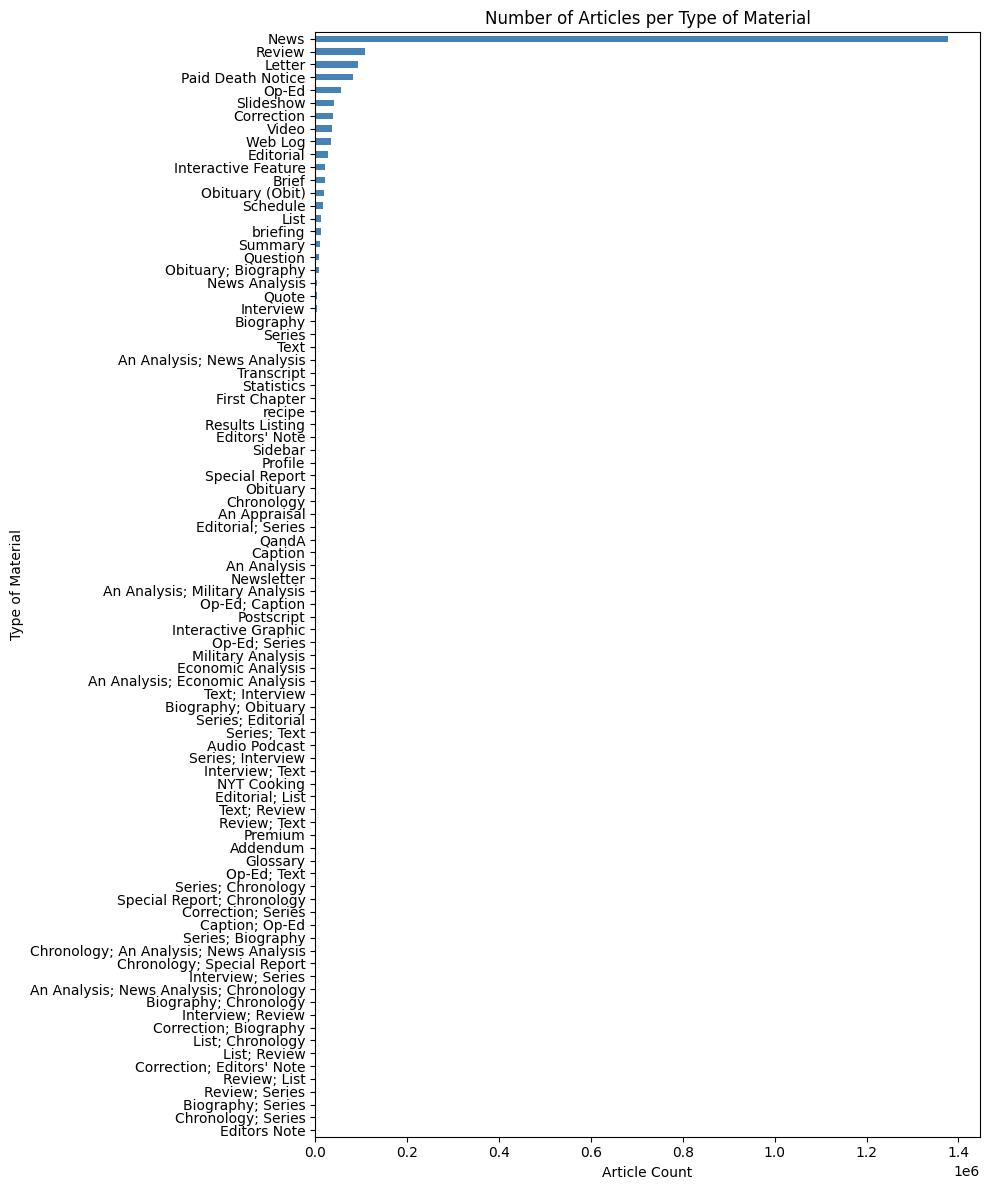

In [ ]:
# We count and sort them before visualizing them
type_counts = df['type_of_material'].value_counts().sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 12))
type_counts.plot(kind='barh', color='steelblue')
plt.title('Number of Articles per Type of Material')
plt.xlabel('Article Count')
plt.ylabel('Type of Material')
plt.tight_layout()
plt.show()

In [ ]:
keep_types = ['News']
#We decided to only keep news, as it was the most relevant for our research question.

df = df[df['type_of_material'].isin(keep_types)]

In [ ]:
# We drop the type of material column as it does not contain anymore variability
df.drop(columns='type_of_material', inplace=True)

In [ ]:
df['section_name'].unique()

array(['Sports', 'U.S.', 'Archives', 'Business Day', 'New York',
       'Technology', 'Arts', 'Books', 'World', 'Theater', 'Education',
       'Movies', 'Real Estate', 'Style', 'Magazine', 'Week in Review',
       'Travel', 'Automobiles', 'Fashion & Style', 'Health', 'Science',
       'Job Market', 'Food', 'Home & Garden', 'Opinion', 'T Magazine',
       'Giving', 'Obituaries', 'The Learning Network', 'membercenter',
       'Climate', 'Your Money', 'Corrections', 'Homepage',
       'readersopinions', 'Crosswords & Games',
       'Great Homes & Destinations', 'Multimedia/Photos', 'Washington',
       'College', 'none', 'Blogs', 'Times Topics', 'Well', 'UrbanEye',
       'Sunday Review', 'Booming', 'International Home', 'The Upshot',
       'Times Insider', 'NYT Now', 'Universal', 'Topics', 'Today’s Paper',
       'Podcasts', 'Briefing', 'Watching', 'Admin', 'Smarter Living',
       'Reader Center', 'Lens', 'Neediest Cases', 'Video', 'Parenting',
       'The Weekly', 'At Home', 'en Españ

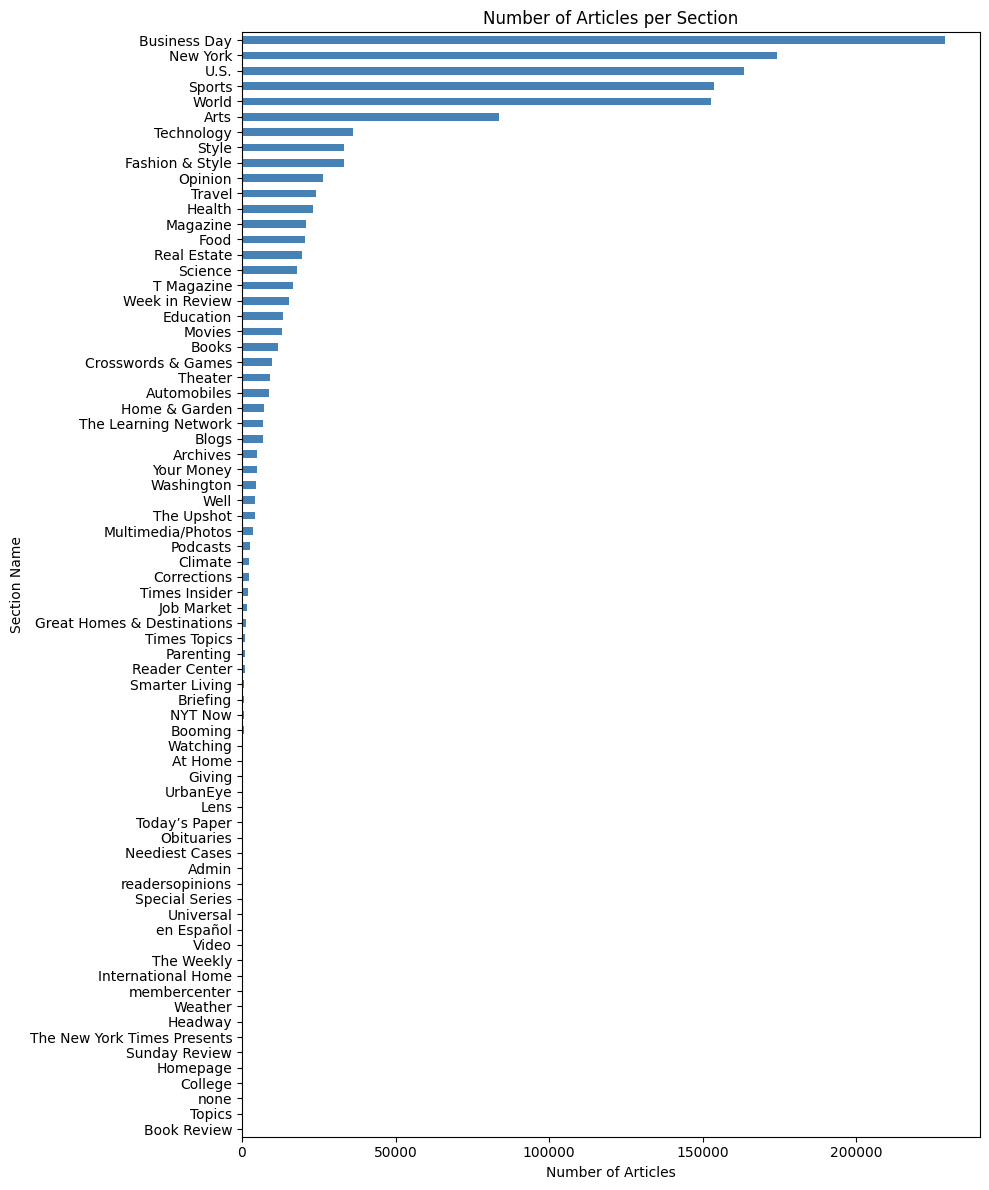

In [ ]:
# Count the number of articles per section
section_counts = df['section_name'].value_counts().sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 12))
section_counts.plot(kind='barh', color='steelblue')
plt.title('Number of Articles per Section')
plt.xlabel('Number of Articles')
plt.ylabel('Section Name')
plt.tight_layout()
plt.show()

In [ ]:
# We filter for the main sections
sections_to_keep = [
    'Business Day', 'New York', 'U.S.', 'Sports', 'World', 'Arts',
    'Technology', 'Style', 'Fashion & Style', 'Opinion', 'Travel',
    'Health', 'Food', 'Real Estate', 'Science',
]

df = df[df['section_name'].isin(sections_to_keep)].copy()

# We merge the 'Style' and 'Fashion & Style' columns
df['section_name'] = df['section_name'].replace(
    {'Style': 'Fashion & Style'}
)


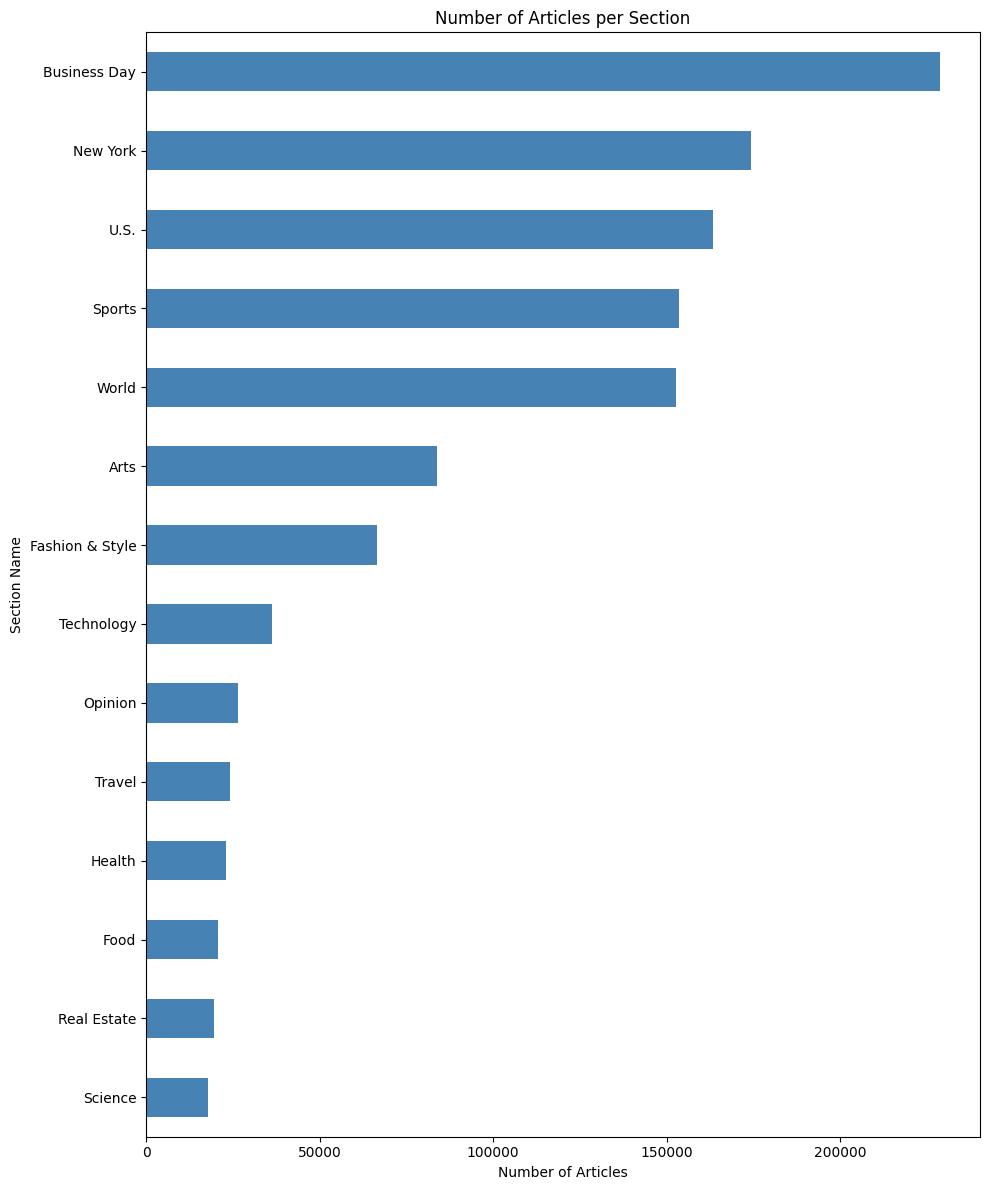

In [ ]:
# Count the number of articles per section
section_counts = df['section_name'].value_counts().sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 12))
section_counts.plot(kind='barh', color='steelblue')
plt.title('Number of Articles per Section')
plt.xlabel('Number of Articles')
plt.ylabel('Section Name')
plt.tight_layout()
plt.show()

In [ ]:

# We futher continue with the cleaning of our dataframe
df['document_type'].unique()

array(['article', 'audiocontainer'], dtype=object)

In [ ]:
# We drop the audiocontainer variable, as we want to focus on text article. We then drop the column as it does not contain anymore relevant information.
to_exclude= ['audiocontainer']
df = df[~df['document_type'].isin(to_exclude)]
df['document_type'].unique()
df.drop(columns='document_type', inplace=True)

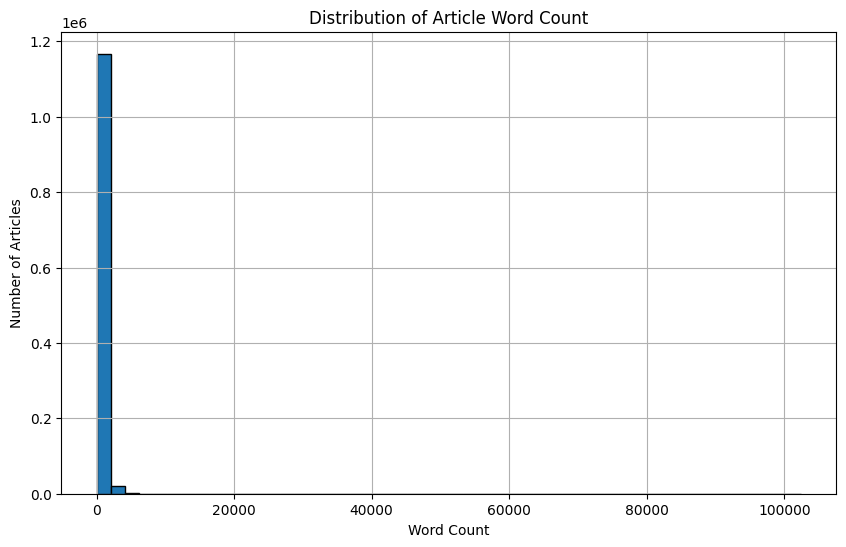

In [ ]:
# We plot the word count histogram
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'].dropna(), bins=50, edgecolor='black')
plt.title('Distribution of Article Word Count')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

In [ ]:
# We analyse the distribution of word count throughout our data frame
min_wc = df['word_count'].min()
max_wc = df['word_count'].max()

print(f"Minimum word count: {min_wc}")
print(f"Maximum word count: {max_wc}")

percentile_01 = df['word_count'].quantile(0.01)
print(f"1st percentile of word count: {percentile_01}")

percentile_99 = df['word_count'].quantile(0.99)
print(f"99th percentile of word count: {percentile_99}")

Minimum word count: 0.0
Maximum word count: 102439.0
1st percentile of word count: 48.0
99th percentile of word count: 2506.7900000000373


In [ ]:
# We filter out the articles with nearly no words and the extreme outliers by setting a threshold at the first and 99th percentile
df = df[(df['word_count'] > 48) & (df['word_count'] < 2500)]

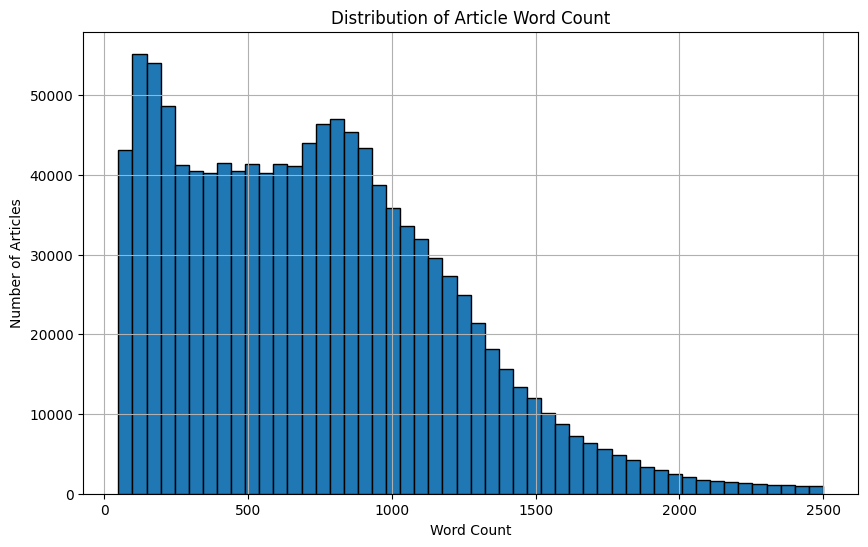

In [ ]:
# Plot Word Count histogram
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'].dropna(), bins=50, edgecolor='black')
plt.title('Distribution of Article Word Count')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

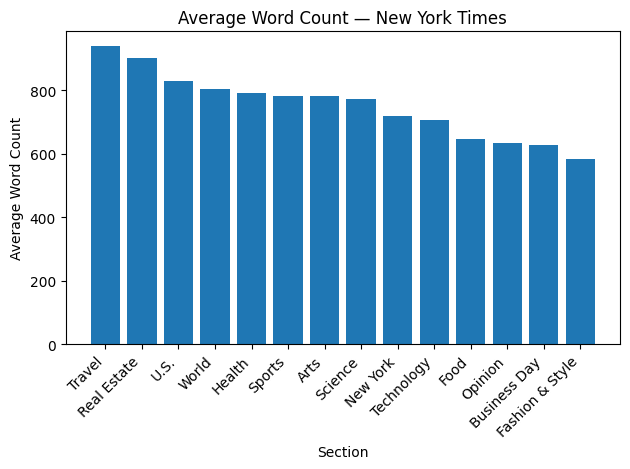

In [ ]:
avg_word_count = (
    df
    .groupby('section_name', as_index=False)['word_count']
    .mean()
    .sort_values('word_count', ascending=False)
)

plt.figure()
plt.bar(avg_word_count['section_name'], avg_word_count['word_count'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Section')
plt.ylabel('Average Word Count')
plt.title('Average Word Count — New York Times')
plt.tight_layout()
plt.show()

In [ ]:
df.shape

(1166762, 9)

In [ ]:
df.head()

,abstract,lead_paragraph,headline,keywords,pub_date,section_name,word_count,year,month
0,Article on upcoming New York Giants-Dallas Cow...,Waiting in the visiting locker room at Texas S...,"{'main': 'Playoffs or No, Dallas Provides The ...","[{'name': 'organizations', 'value': 'New York ...",2000-01-01 05:00:00+00:00,Sports,819.0,2000,1
2,Many experts on Y2K computer problem report th...,As the world slid nervously yesterday through ...,"{'main': ""Internet's Cheering Squad Nervously ...","[{'name': 'subject', 'value': 'Electronic Mail...",2000-01-01 05:00:00+00:00,U.S.,761.0,2000,1
6,Article on Florida State offensive tackle Todd...,The former high school superstars thought they...,{'main': 'COLLEGE FOOTBALL; From Homeless to a...,"[{'name': 'organizations', 'value': 'Florida S...",2000-01-01 05:00:00+00:00,Sports,1178.0,2000,1
8,Judge D Irvin Couvillion rules that Burton W K...,A Tax Court judge has ruled that one of the na...,{'main': 'Tax Lawyer Called Architect of a Tax...,"[{'name': 'organizations', 'value': 'Travelers...",2000-01-01 05:00:00+00:00,Business Day,1317.0,2000,1
10,"Joshua Davis, high school student from Montcla...","Joshua Davis, 17, has been counting down each ...",{'main': 'Folds of Newspapers Yield Symbols of...,"[{'name': 'glocations', 'value': 'Montclair (N...",2000-01-01 05:00:00+00:00,New York,661.0,2000,1


In [ ]:
# Total number of articles per section
section_counts = df['section_name'].value_counts().sort_values(ascending=False)

# Print the result
print(section_counts)

section_name
Business Day       223704
New York           169608
U.S.               160571
Sports             151470
World              151053
Arts                81399
Fashion & Style     65411
Technology          35892
Opinion             24780
Travel              23041
Health              22794
Food                20099
Real Estate         19136
Science             17804
Name: count, dtype: int64


In [ ]:
# Set the number of samples per section
N = 10000

# Sample with replacement to ensure 10,000 per section even if some have fewer articles
sampled_df = df.groupby('section_name', group_keys=False).apply(
    lambda x: x.sample(n=N, replace=True, random_state=42)
)

C:\Users\maiwe\AppData\Local\Temp\ipykernel_46888\126741732.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('section_name', group_keys=False).apply(


In [ ]:
sampled_df.head()

,abstract,lead_paragraph,headline,keywords,pub_date,section_name,word_count,year,month
656551,You might say that ''Sit Down Comedy With Davi...,"You might say that ""Sit Down Comedy With David...","{'main': 'A Comic Walks Into a TV Studio, and ...","[{'name': 'organizations', 'value': 'TV Land',...",2005-12-14 05:00:00+00:00,Arts,1024.0,2005,12
39433,Jazz at Lincoln Center plans for its new home ...,A dance floor with a 50-foot window on Central...,{'main': 'Jazz Suite With a Park View; Lincoln...,"[{'name': 'glocations', 'value': 'COLUMBUS CIR...",2000-05-23 05:00:00+00:00,Arts,1394.0,2000,5
2103127,The restoration of a statue the artist created...,"FLORENCE, Italy — Michelangelo was an old man ...",{'main': 'Bringing a Deathly Michelangelo Scul...,"[{'name': 'persons', 'value': 'Buonarroti, Mic...",2021-09-27 17:42:51+00:00,Arts,1005.0,2021,9
1697124,Mr. Kaufmann canceled his first scheduled perf...,It was one of the hottest opera tickets of the...,{'main': 'Jonas Kaufmann Cancels Wednesday’s ‘...,"[{'name': 'subject', 'value': 'Opera', 'rank':...",2015-03-02 16:44:15+00:00,Arts,200.0,2015,3
291916,"John Rockwell interviews composer John Adams, ...","Ever since Sept. 11 of last year, artists have...",{'main': 'Challenge of the Unthinkable; John A...,"[{'name': 'organizations', 'value': 'New York ...",2002-09-17 05:00:00+00:00,Arts,1607.0,2002,9


In [ ]:
to_drop=['keywords', 'pub_date']
sampled_df.drop(columns=to_drop, inplace=True)

In [ ]:
# Print the first 10 raw headline entries as-is
for i, headline in enumerate(sampled_df['headline'].dropna().head(10), 1):
    print(f"{i}. {headline}")


1. {'main': 'A Comic Walks Into a TV Studio, and He Turns to Another Comic...', 'kicker': None, 'content_kicker': None, 'print_headline': 'See, This Comic Walks Into a TV Studio, and He Turns to Another Comic', 'name': None, 'seo': None, 'sub': None}
2. {'main': 'Jazz Suite With a Park View; Lincoln Center Unveils Its Columbus Circle Plan', 'kicker': None, 'content_kicker': None, 'print_headline': 'Jazz Suite With a Park View; Lincoln Center Unveils Its Columbus Circle Plan', 'name': None, 'seo': None, 'sub': None}
3. {'main': 'Bringing a Deathly Michelangelo Sculpture Back to Life', 'kicker': None, 'content_kicker': None, 'print_headline': 'A Michelangelo Restored at Last', 'name': None, 'seo': None, 'sub': None}
4. {'main': 'Jonas Kaufmann Cancels Wednesday’s ‘Carmen’ at the Met', 'kicker': 'ArtsBeat', 'content_kicker': None, 'print_headline': '', 'name': None, 'seo': None, 'sub': None}
5. {'main': 'Challenge of the Unthinkable; John Adams Delivers a Commissioned Work on 9/11', 'kick

In [ ]:
# Extract the 'main' field from the headline column
sampled_df['headline'] = sampled_df['headline'].dropna().apply(
    lambda x: ast.literal_eval(x).get('main', '[No headline]')
)

In [ ]:
print(sampled_df['headline'].head(10))

656551     A Comic Walks Into a TV Studio, and He Turns t...
39433      Jazz Suite With a Park View; Lincoln Center Un...
2103127    Bringing a Deathly Michelangelo Sculpture Back...
1697124    Jonas Kaufmann Cancels Wednesday’s ‘Carmen’ at...
291916     Challenge of the Unthinkable; John Adams Deliv...
1264954                Hendrix and Handel but Mostly Hendrix
1477190                      ‘War Horse’ to Close in January
1796865    In 3 New Travel Series, the Comic, the Solemn ...
661303     At City Ballet, Some Especially Catch the Eye;...
1405371                Preserving Artifacts of Anti-Semitism
Name: headline, dtype: object


In [ ]:
sampled_df.shape

(140000, 7)

In [ ]:
sampled_df.head()

,abstract,lead_paragraph,headline,section_name,word_count,year,month
656551,You might say that ''Sit Down Comedy With Davi...,"You might say that ""Sit Down Comedy With David...","A Comic Walks Into a TV Studio, and He Turns t...",Arts,1024.0,2005,12
39433,Jazz at Lincoln Center plans for its new home ...,A dance floor with a 50-foot window on Central...,Jazz Suite With a Park View; Lincoln Center Un...,Arts,1394.0,2000,5
2103127,The restoration of a statue the artist created...,"FLORENCE, Italy — Michelangelo was an old man ...",Bringing a Deathly Michelangelo Sculpture Back...,Arts,1005.0,2021,9
1697124,Mr. Kaufmann canceled his first scheduled perf...,It was one of the hottest opera tickets of the...,Jonas Kaufmann Cancels Wednesday’s ‘Carmen’ at...,Arts,200.0,2015,3
291916,"John Rockwell interviews composer John Adams, ...","Ever since Sept. 11 of last year, artists have...",Challenge of the Unthinkable; John Adams Deliv...,Arts,1607.0,2002,9


## Data frame preparation
 - explain 2 diffrent ways

In [ ]:
# Setup stopwords
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = word_tokenize(text)
    clean_tokens = [
        tok for tok in tokens
        if tok.isalpha() and tok not in stop_words and len(tok) > 1
    ]
    return " ".join(clean_tokens)


# Lemmatization will be done later, as not all models needs lematization.

In [ ]:
TAG_RE = re.compile(r"<[^>]+>")

def light_clean(text: str) -> str:
    txt = TAG_RE.sub(" ", str(text))
    txt = re.sub(r"\s+", " ", txt)
    return txt.strip()


In [ ]:
# ligheter clean for bert compared to other models
sampled_df["text_raw"] = (
      sampled_df["headline"].fillna("") + " "
    + sampled_df["lead_paragraph"].fillna("") + " "
    + sampled_df["abstract"].fillna("")
).apply(light_clean)          # <-- HTML removal + whitespace only

sampled_df["text_clean"] = sampled_df["text_raw"].apply(preprocess_text)


In [ ]:
sampled_df.head()

,abstract,lead_paragraph,headline,section_name,word_count,year,month,text_raw,text_clean
656551,You might say that ''Sit Down Comedy With Davi...,"You might say that ""Sit Down Comedy With David...","A Comic Walks Into a TV Studio, and He Turns t...",Arts,1024.0,2005,12,"A Comic Walks Into a TV Studio, and He Turns t...",comic walks tv studio turns another comic migh...
39433,Jazz at Lincoln Center plans for its new home ...,A dance floor with a 50-foot window on Central...,Jazz Suite With a Park View; Lincoln Center Un...,Arts,1394.0,2000,5,Jazz Suite With a Park View; Lincoln Center Un...,jazz suite park view lincoln center unveils co...
2103127,The restoration of a statue the artist created...,"FLORENCE, Italy — Michelangelo was an old man ...",Bringing a Deathly Michelangelo Sculpture Back...,Arts,1005.0,2021,9,Bringing a Deathly Michelangelo Sculpture Back...,bringing deathly michelangelo sculpture back l...
1697124,Mr. Kaufmann canceled his first scheduled perf...,It was one of the hottest opera tickets of the...,Jonas Kaufmann Cancels Wednesday’s ‘Carmen’ at...,Arts,200.0,2015,3,Jonas Kaufmann Cancels Wednesday’s ‘Carmen’ at...,jonas kaufmann cancels wednesday carmen met on...
291916,"John Rockwell interviews composer John Adams, ...","Ever since Sept. 11 of last year, artists have...",Challenge of the Unthinkable; John Adams Deliv...,Arts,1607.0,2002,9,Challenge of the Unthinkable; John Adams Deliv...,challenge unthinkable john adams delivers comm...


## Sentiment Analysis with Vader

In [ ]:
# Initialize the VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Compute sentiment for each text
scores = sampled_df['text_clean'].astype(str) \
                   .apply(analyzer.polarity_scores)

# Build a DataFrame *with the same index as sampled_df
sentiment_df = pd.DataFrame(list(scores),
                            index=sampled_df.index)

sampled_df[['neg','neu','pos','compound']] = sentiment_df

sampled_df.head()

,abstract,lead_paragraph,headline,section_name,word_count,year,month,text_raw,text_clean,neg,neu,pos,compound
656551,You might say that ''Sit Down Comedy With Davi...,"You might say that ""Sit Down Comedy With David...","A Comic Walks Into a TV Studio, and He Turns t...",Arts,1024.0,2005,12,"A Comic Walks Into a TV Studio, and He Turns t...",comic walks tv studio turns another comic migh...,0.000,0.789,0.211,0.8591
39433,Jazz at Lincoln Center plans for its new home ...,A dance floor with a 50-foot window on Central...,Jazz Suite With a Park View; Lincoln Center Un...,Arts,1394.0,2000,5,Jazz Suite With a Park View; Lincoln Center Un...,jazz suite park view lincoln center unveils co...,0.000,1.000,0.000,0.0000
2103127,The restoration of a statue the artist created...,"FLORENCE, Italy — Michelangelo was an old man ...",Bringing a Deathly Michelangelo Sculpture Back...,Arts,1005.0,2021,9,Bringing a Deathly Michelangelo Sculpture Back...,bringing deathly michelangelo sculpture back l...,0.000,0.915,0.085,0.5106
1697124,Mr. Kaufmann canceled his first scheduled perf...,It was one of the hottest opera tickets of the...,Jonas Kaufmann Cancels Wednesday’s ‘Carmen’ at...,Arts,200.0,2015,3,Jonas Kaufmann Cancels Wednesday’s ‘Carmen’ at...,jonas kaufmann cancels wednesday carmen met on...,0.154,0.789,0.057,-0.5859
291916,"John Rockwell interviews composer John Adams, ...","Ever since Sept. 11 of last year, artists have...",Challenge of the Unthinkable; John Adams Deliv...,Arts,1607.0,2002,9,Challenge of the Unthinkable; John Adams Deliv...,challenge unthinkable john adams delivers comm...,0.301,0.617,0.083,-0.9477


In [ ]:
def spacy_lemmatize(text, stop_words):
    if pd.isna(text) or not text:
        return ""
    doc = nlp(text)
    return " ".join(
        tok.lemma_.lower()
        for tok in doc
        if tok.is_alpha
        and tok.lemma_.lower() not in stop_words
        and len(tok.lemma_) > 1
    )

sampled_df["text_clean"] = sampled_df["text_clean"].apply(
    lambda txt: spacy_lemmatize(txt, stop_words)
)


In [ ]:
sampled_df.head()

,abstract,lead_paragraph,headline,section_name,word_count,year,month,text_raw,text_clean,neg,neu,pos,compound
656551,You might say that ''Sit Down Comedy With Davi...,"You might say that ""Sit Down Comedy With David...","A Comic Walks Into a TV Studio, and He Turns t...",Arts,1024.0,2005,12,"A Comic Walks Into a TV Studio, and He Turns t...",comic walks tv studio turn another comic might...,0.000,0.789,0.211,0.8591
39433,Jazz at Lincoln Center plans for its new home ...,A dance floor with a 50-foot window on Central...,Jazz Suite With a Park View; Lincoln Center Un...,Arts,1394.0,2000,5,Jazz Suite With a Park View; Lincoln Center Un...,jazz suite park view lincoln center unveil col...,0.000,1.000,0.000,0.0000
2103127,The restoration of a statue the artist created...,"FLORENCE, Italy — Michelangelo was an old man ...",Bringing a Deathly Michelangelo Sculpture Back...,Arts,1005.0,2021,9,Bringing a Deathly Michelangelo Sculpture Back...,bring deathly michelangelo sculpture back life...,0.000,0.915,0.085,0.5106
1697124,Mr. Kaufmann canceled his first scheduled perf...,It was one of the hottest opera tickets of the...,Jonas Kaufmann Cancels Wednesday’s ‘Carmen’ at...,Arts,200.0,2015,3,Jonas Kaufmann Cancels Wednesday’s ‘Carmen’ at...,jonas kaufmann cancels wednesday carman meet o...,0.154,0.789,0.057,-0.5859
291916,"John Rockwell interviews composer John Adams, ...","Ever since Sept. 11 of last year, artists have...",Challenge of the Unthinkable; John Adams Deliv...,Arts,1607.0,2002,9,Challenge of the Unthinkable; John Adams Deliv...,challenge unthinkable john adams deliver commi...,0.301,0.617,0.083,-0.9477


## Sentiment Analysis - EDA

In [ ]:
# Overall sentiment summary
overall = sampled_df['compound'].agg(['mean', 'std', 'min', 'max']).rename({
    'mean': 'Mean',
    'std':  'StdDev',
    'min':  'Min',
    'max':  'Max'
})
print("=== Overall Sentiment Summary ===")
print(overall.to_frame().T)

=== Overall Sentiment Summary ===
              Mean    StdDev     Min     Max
compound  0.161186  0.638649 -0.9996  0.9994


In [ ]:
# Summary per section
sec_summary = (
    sampled_df
    .groupby('section_name')['compound']
    .agg(['mean','std','count'])
    .rename(columns={'mean':'Mean','std':'StdDev','count':'N'})
    .sort_values('Mean', ascending=False)
)
print("\n=== Sentiment by Section ===")
print(sec_summary)


=== Sentiment by Section ===
                     Mean    StdDev      N
section_name                              
Food             0.504175  0.465364  10000
Travel           0.432312  0.522607  10000
Arts             0.334751  0.598825  10000
Fashion & Style  0.331498  0.480580  10000
Sports           0.261932  0.603972  10000
Technology       0.247781  0.558630  10000
Real Estate      0.243141  0.494144  10000
Business Day     0.172752  0.639453  10000
Science          0.145074  0.589552  10000
Opinion          0.042607  0.649607  10000
Health          -0.026162  0.681423  10000
New York        -0.069481  0.690002  10000
U.S.            -0.074056  0.693279  10000
World           -0.289727  0.689067  10000


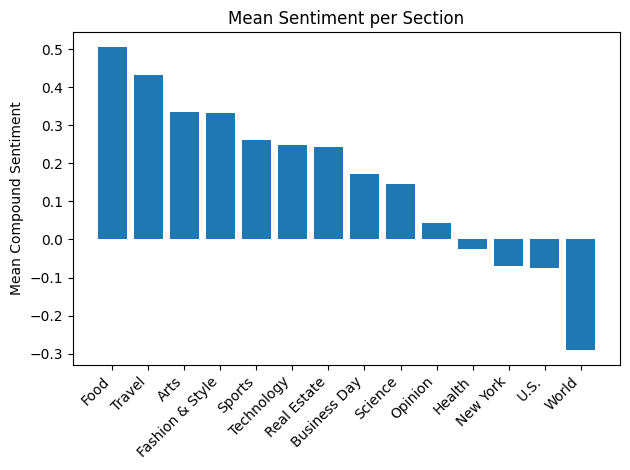

In [ ]:
# Bar chart: mean by section
plt.figure()
plt.bar(sec_summary.index, sec_summary['Mean'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean Compound Sentiment')
plt.title('Mean Sentiment per Section')
plt.tight_layout()
plt.show()

C:\Users\maiwe\AppData\Local\Temp\ipykernel_46888\3737585702.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sec_summary.index)


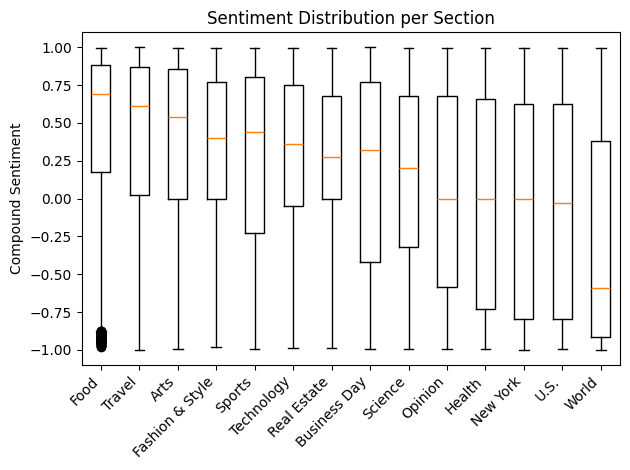

In [ ]:
# Boxplot: distribution by section
plt.figure()
data = [sampled_df.loc[sampled_df['section_name']==sec, 'compound'].dropna()
        for sec in sec_summary.index]
plt.boxplot(data, labels=sec_summary.index)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Compound Sentiment')
plt.title('Sentiment Distribution per Section')
plt.tight_layout()
plt.show()

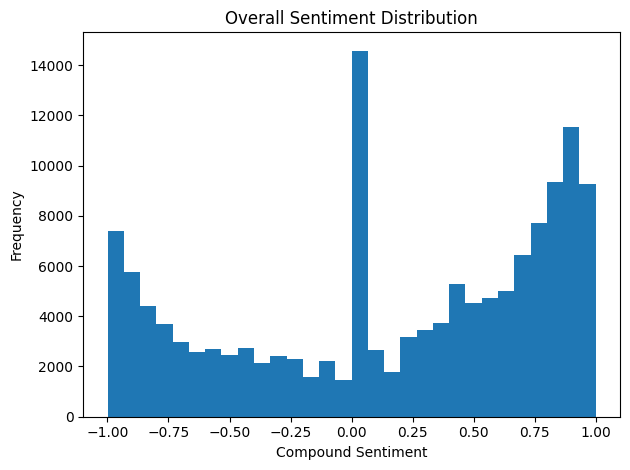

In [ ]:
# Histogram: overall distribution
plt.figure()
plt.hist(sampled_df['compound'].dropna(), bins=30)
plt.xlabel('Compound Sentiment')
plt.ylabel('Frequency')
plt.title('Overall Sentiment Distribution')
plt.tight_layout()
plt.show()


C:\Users\maiwe\AppData\Local\Temp\ipykernel_46888\3229636588.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['Word'], rotation=45, ha='right')
C:\Users\maiwe\AppData\Local\Temp\ipykernel_46888\3229636588.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['Word'], rotation=45, ha='right')
C:\Users\maiwe\AppData\Local\Temp\ipykernel_46888\3229636588.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['Word'], rotation=45, ha='right')
C:\Users\maiwe\AppData\Local\Temp\ipykernel_46888\3229636588.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['Word'], r

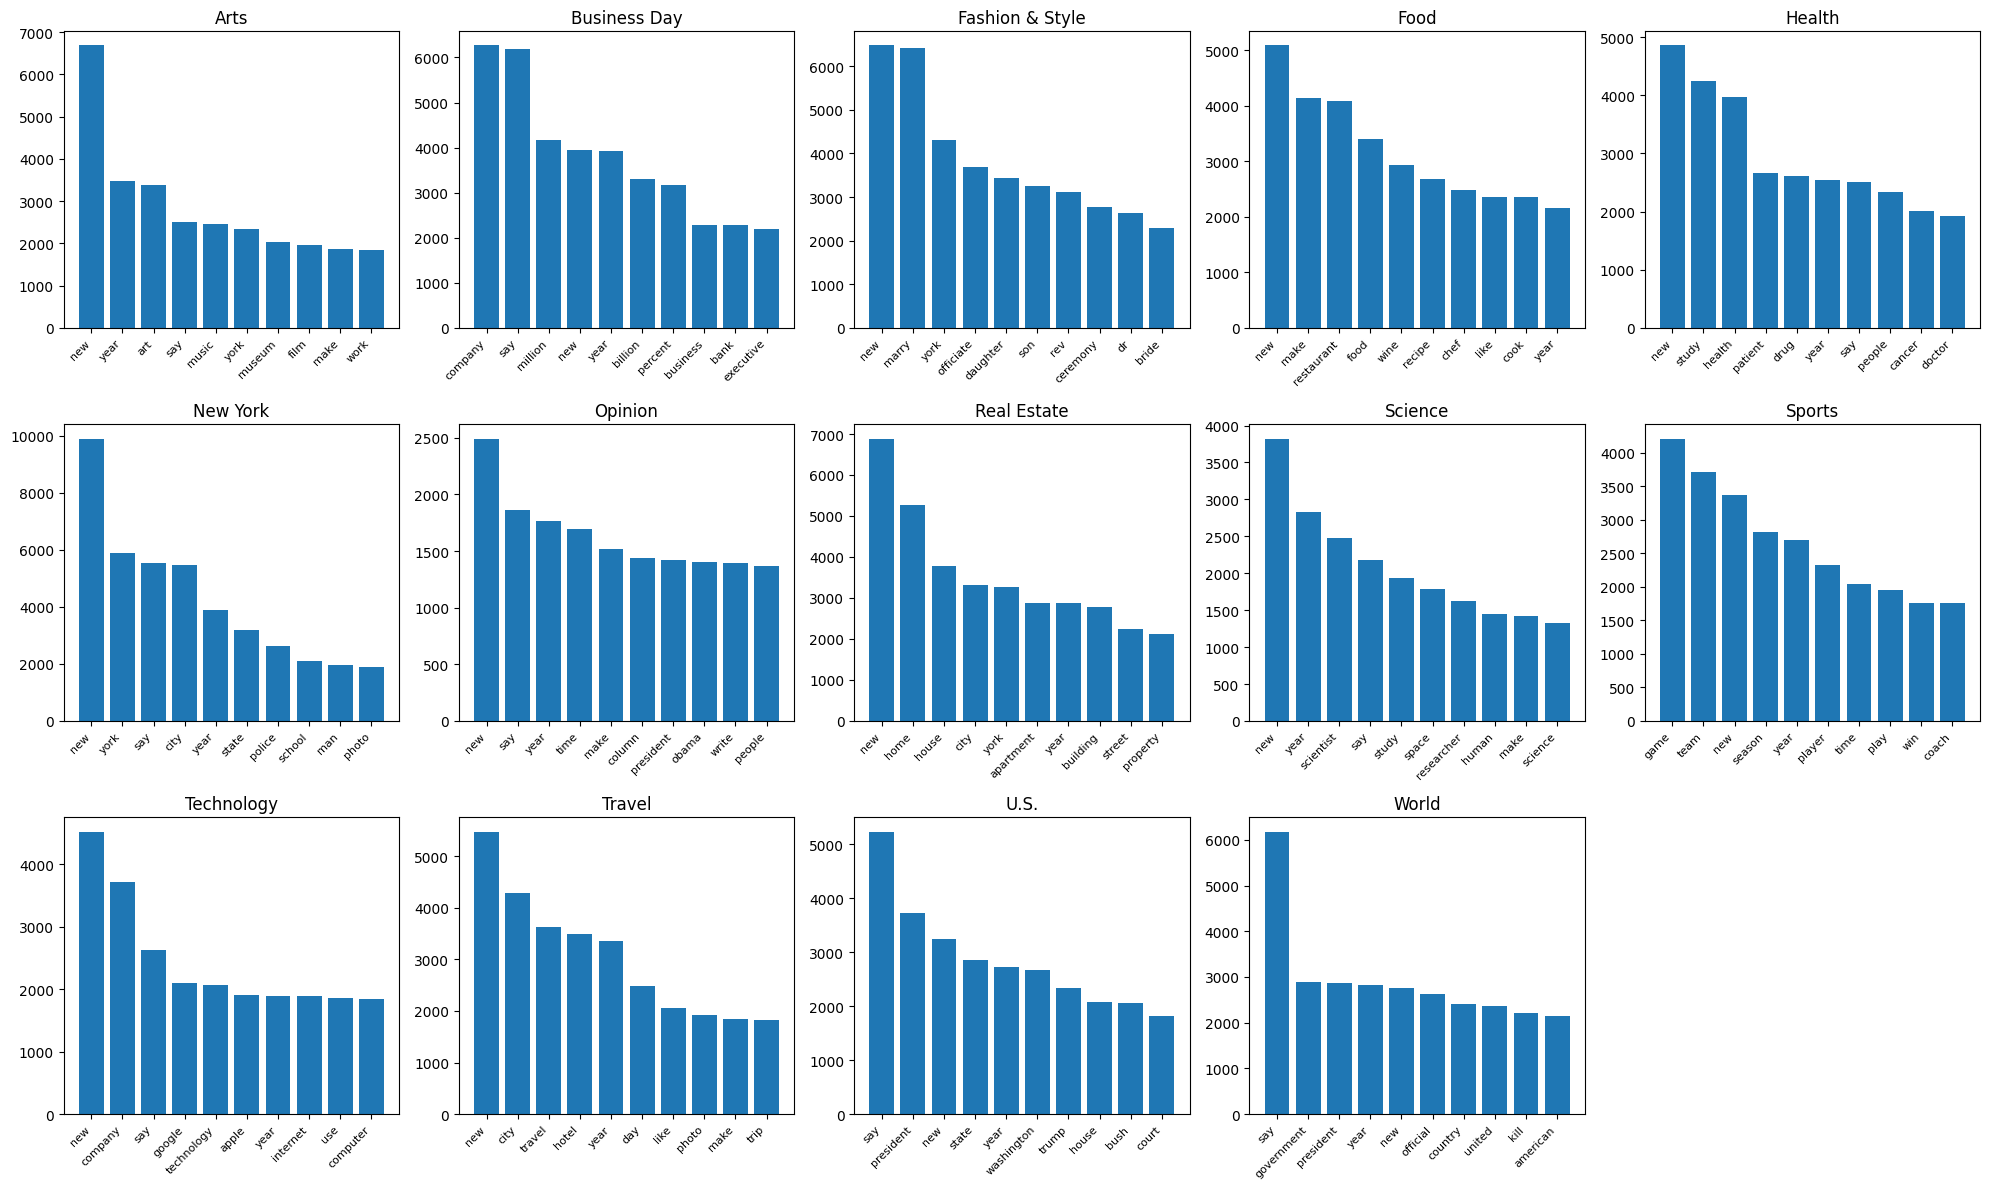

In [ ]:

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(sampled_df['text_clean'])
feature_names = vectorizer.get_feature_names_out()

# Compute top 10 words per section
rows = []
for sec in sampled_df['section_name'].unique():
    # Convert the boolean mask to a numpy array
    mask = (sampled_df['section_name'] == sec).to_numpy()
    # Use integer indexing on the sparse matrix
    indices = np.nonzero(mask)[0]
    X_sec = X[indices]                # subset rows by index array
    counts = X_sec.sum(axis=0).A1     # total count per term
    top_idx = counts.argsort()[::-1][:10]
    for idx in top_idx:
        rows.append({
            'Section': sec,
            'Word':    feature_names[idx],
            'Count':   int(counts[idx])
        })

df_top10 = pd.DataFrame(rows)

sections = df_top10['Section'].unique()
n_sections = len(sections)
n_cols = 5
n_rows = int(np.ceil(n_sections / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axs = axs.flatten()

for i, sec in enumerate(sections):
    ax = axs[i]
    data = df_top10[df_top10['Section'] == sec]
    ax.bar(data['Word'], data['Count'])
    ax.set_title(sec)
    ax.set_xticklabels(data['Word'], rotation=45, ha='right')
    ax.tick_params(axis='x', labelsize=8)


for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

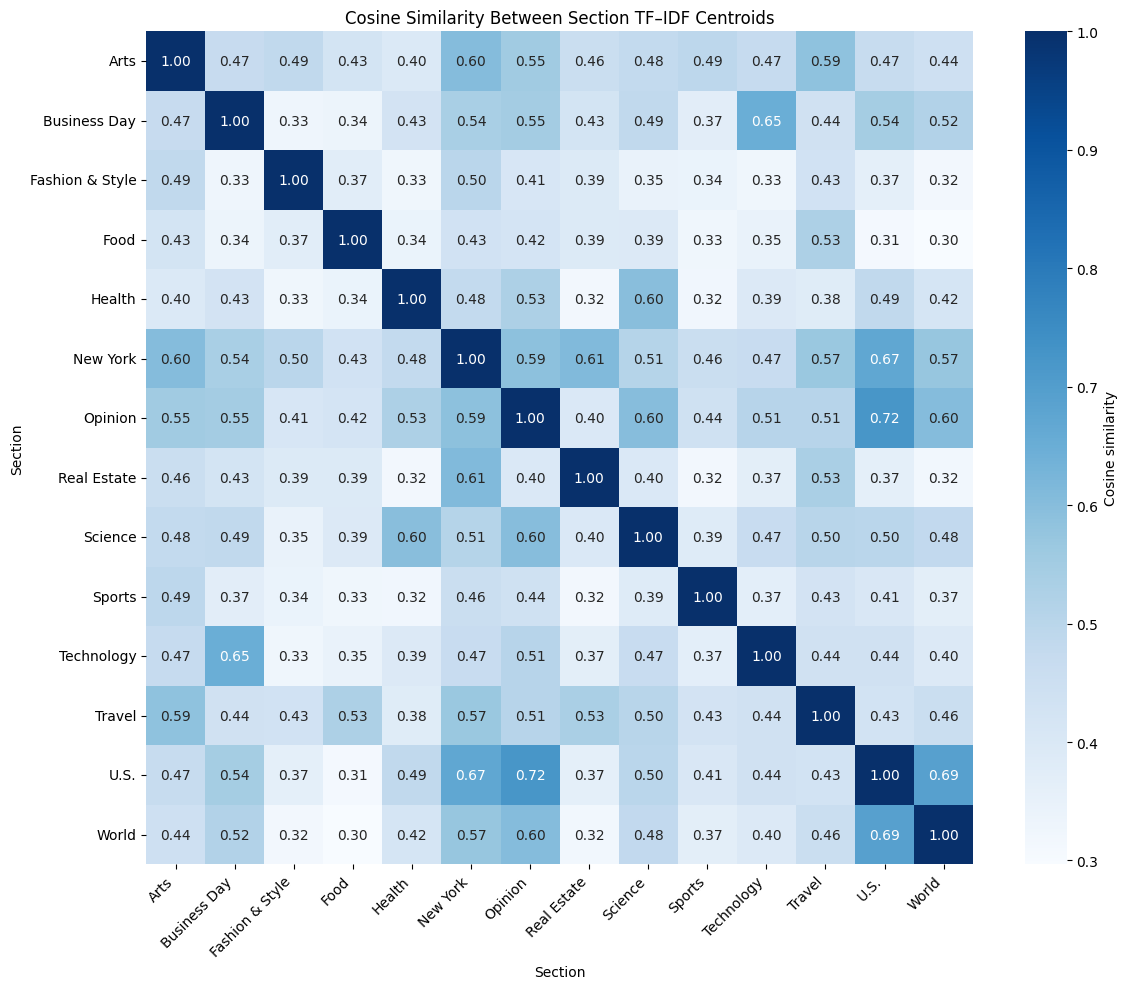

In [ ]:
# Cosine similarity Matrix
from sklearn.metrics.pairwise import cosine_similarity

# Vectorize all articles with TF–IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(sampled_df['text_clean'])

# Compute one centroid per section (mean TF–IDF vector)
sections = sampled_df['section_name'].unique()
centroids = []
for sec in sections:
    mask     = sampled_df['section_name'] == sec
    X_sec    = X_tfidf[mask]
    centroid = X_sec.mean(axis=0)
    centroids.append(centroid)
# stack into a dense array of shape (n_sections, n_features)
centroids = np.vstack([c.A1 for c in centroids])

# Compute cosine‐similarity between centroids
sim = cosine_similarity(centroids)

# Build a DataFrame for easy labeling
sim_df = pd.DataFrame(sim, index=sections, columns=sections)

# Plot as a heatmap
plt.figure(figsize=(12,10))
sns.heatmap(
    sim_df,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={"label": "Cosine similarity"}
)
plt.title("Cosine Similarity Between Section TF–IDF Centroids")
plt.xlabel("Section")
plt.ylabel("Section")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification task


In [ ]:
sampled_df.head()

,abstract,lead_paragraph,headline,section_name,word_count,year,month,text_raw,text_clean,neg,neu,pos,compound
656551,You might say that ''Sit Down Comedy With Davi...,"You might say that ""Sit Down Comedy With David...","A Comic Walks Into a TV Studio, and He Turns t...",Arts,1024.0,2005,12,"A Comic Walks Into a TV Studio, and He Turns t...",comic walks tv studio turn another comic might...,0.000,0.789,0.211,0.8591
39433,Jazz at Lincoln Center plans for its new home ...,A dance floor with a 50-foot window on Central...,Jazz Suite With a Park View; Lincoln Center Un...,Arts,1394.0,2000,5,Jazz Suite With a Park View; Lincoln Center Un...,jazz suite park view lincoln center unveil col...,0.000,1.000,0.000,0.0000
2103127,The restoration of a statue the artist created...,"FLORENCE, Italy — Michelangelo was an old man ...",Bringing a Deathly Michelangelo Sculpture Back...,Arts,1005.0,2021,9,Bringing a Deathly Michelangelo Sculpture Back...,bring deathly michelangelo sculpture back life...,0.000,0.915,0.085,0.5106
1697124,Mr. Kaufmann canceled his first scheduled perf...,It was one of the hottest opera tickets of the...,Jonas Kaufmann Cancels Wednesday’s ‘Carmen’ at...,Arts,200.0,2015,3,Jonas Kaufmann Cancels Wednesday’s ‘Carmen’ at...,jonas kaufmann cancels wednesday carman meet o...,0.154,0.789,0.057,-0.5859
291916,"John Rockwell interviews composer John Adams, ...","Ever since Sept. 11 of last year, artists have...",Challenge of the Unthinkable; John Adams Deliv...,Arts,1607.0,2002,9,Challenge of the Unthinkable; John Adams Deliv...,challenge unthinkable john adams deliver commi...,0.301,0.617,0.083,-0.9477


In [ ]:
sampled_df.shape

(140000, 13)

## Train Val Test split

In [ ]:
# Encode the section_name column into numerical labels
label_encoder = LabelEncoder()
sampled_df['label'] = label_encoder.fit_transform(sampled_df['section_name'])

label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label mapping:", label_mapping)

#train/val/test split
X = sampled_df[["text_raw", "text_clean", "neg", "neu", "pos", "compound"]]
y = sampled_df["label"]

# First split: train+val (85%) vs. test (15%)
trainval_df, test_df, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# Second split: train (70%) vs. val (15%) of the original data
val_frac = 0.15 / 0.85
train_df, val_df, y_train, y_val = train_test_split(
    trainval_df, y_train_val,
    test_size=val_frac,
    stratify=y_train_val,
    random_state=42
)

print(f"Train:      {len(train_df):5d} samples ({len(train_df)/len(sampled_df):.1%})")
print(f"Validation: {len(val_df):5d} samples ({len(val_df)/len(sampled_df):.1%})")
print(f"Test:       {len(test_df):5d} samples ({len(test_df)/len(sampled_df):.1%})\n")

print("Class proportions in each split:")
print(" Train:\n", y_train.value_counts(normalize=True).sort_index())
print(" Val:\n",   y_val.value_counts(normalize=True).sort_index())
print(" Test:\n",  y_test.value_counts(normalize=True).sort_index())

Label mapping: {'Arts': 0, 'Business Day': 1, 'Fashion & Style': 2, 'Food': 3, 'Health': 4, 'New York': 5, 'Opinion': 6, 'Real Estate': 7, 'Science': 8, 'Sports': 9, 'Technology': 10, 'Travel': 11, 'U.S.': 12, 'World': 13}
Train:      98000 samples (70.0%)
Validation: 21000 samples (15.0%)
Test:       21000 samples (15.0%)

Class proportions in each split:
 Train:
 label
0     0.071429
1     0.071429
2     0.071429
3     0.071429
4     0.071429
5     0.071429
6     0.071429
7     0.071429
8     0.071429
9     0.071429
10    0.071429
11    0.071429
12    0.071429
13    0.071429
Name: proportion, dtype: float64
 Val:
 label
0     0.071429
1     0.071429
2     0.071429
3     0.071429
4     0.071429
5     0.071429
6     0.071429
7     0.071429
8     0.071429
9     0.071429
10    0.071429
11    0.071429
12    0.071429
13    0.071429
Name: proportion, dtype: float64
 Test:
 label
0     0.071429
1     0.071429
2     0.071429
3     0.071429
4     0.071429
5     0.071429
6     0.071429
7     0.

## Evaluation function

In [ ]:
def evaluate_model(name,
                   y_true,
                   y_pred,
                   y_score=None,
                   label_encoder=None):

    labels = sorted(np.unique(y_true))

    if label_encoder is not None:
        target_names = label_encoder.inverse_transform(labels)
    else:
        target_names = [str(l) for l in labels]

    print(f"\n=== Performance Report: {name} ===\n")

    #Classification report with section names
    print(classification_report(
        y_true, y_pred,
        labels=labels,
        target_names=target_names
    ))

    #Overall accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}\n")

    #Macro‐ & Weighted‐averaged precision, recall, F1
    metrics = {
        "Precision": precision_score,
        "Recall":    recall_score,
        "F1 Score":  f1_score
    }
    print("Metric      Macro Avg   Weighted Avg")
    print("------      ---------   ------------")
    for metric_name, fn in metrics.items():
        m_macro    = fn(y_true, y_pred, average='macro')
        m_weighted = fn(y_true, y_pred, average='weighted')
        print(f"{metric_name:<11}{m_macro:>10.4f}{m_weighted:>13.4f}")
    print()

    #Log-loss
    if y_score is not None:
        try:
            ll = log_loss(y_true, y_score, labels=labels)
            print(f"Log Loss: {ll:.4f}\n")
        except Exception as e:
            print(f"Could not compute log_loss: {e}\n")

    #Confusion matrix (normalized)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=target_names,
        yticklabels=target_names
    )
    plt.title(f"{name} — Normalized Confusion Matrix")
    plt.xlabel("Predicted Section")
    plt.ylabel("True Section")
    plt.tight_layout()
    plt.show()


## Basic Naive Bayes

Training Accuracy: 0.7624
Training F1-score: 0.7604

=== Performance Report: Basic Naive Bayes — Test Set ===

                 precision    recall  f1-score   support

           Arts       0.67      0.80      0.73      1500
   Business Day       0.70      0.67      0.69      1500
Fashion & Style       0.86      0.63      0.72      1500
           Food       0.75      0.89      0.82      1500
         Health       0.70      0.76      0.73      1500
       New York       0.76      0.62      0.68      1500
        Opinion       0.67      0.53      0.60      1500
    Real Estate       0.81      0.82      0.81      1500
        Science       0.69      0.69      0.69      1500
         Sports       0.89      0.92      0.90      1500
     Technology       0.76      0.79      0.77      1500
         Travel       0.68      0.74      0.71      1500
           U.S.       0.65      0.64      0.64      1500
          World       0.75      0.80      0.77      1500

       accuracy                 

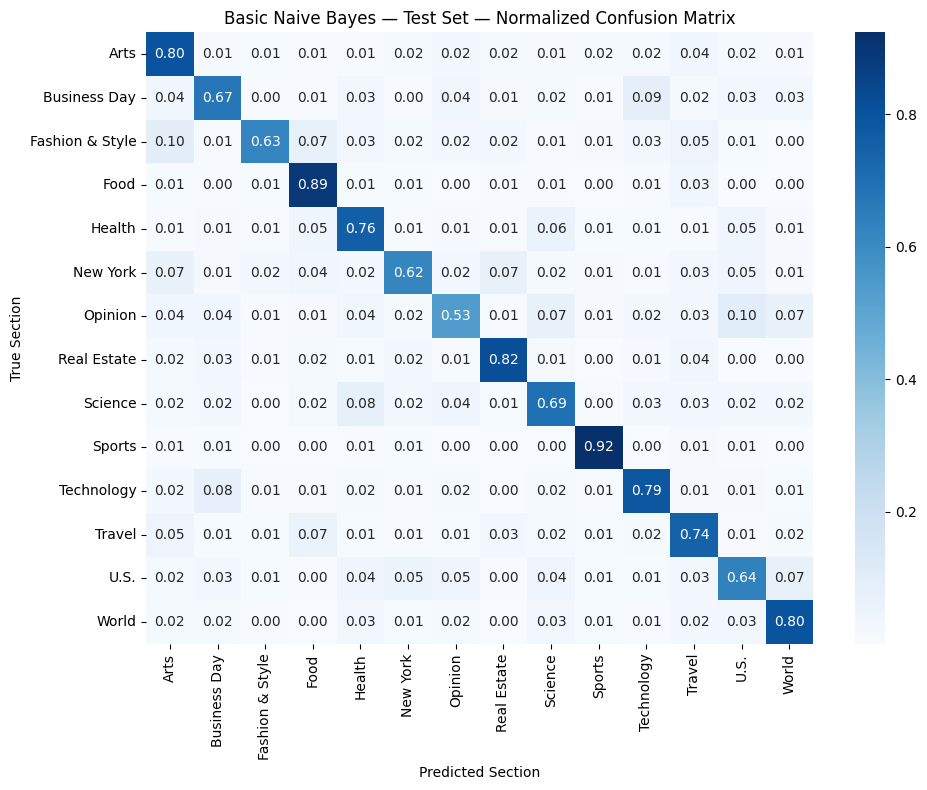

In [ ]:
# train on train+val data
basic_nb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10_000, ngram_range=(1, 2))),
    ("clf", MultinomialNB())
])

basic_nb_pipeline.fit(trainval_df["text_clean"], y_train_val)

# Predict on training data
y_train_pred  = basic_nb_pipeline.predict(trainval_df["text_clean"])
y_train_proba = basic_nb_pipeline.predict_proba(trainval_df["text_clean"])
train_accuracy = accuracy_score(y_train_val, y_train_pred)
train_f1 = f1_score(y_train_val, y_train_pred, average='weighted')  # or 'macro'
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training F1-score: {train_f1:.4f}")

# Evaluate on the test set
y_test_pred  = basic_nb_pipeline.predict(test_df["text_clean"])
y_test_proba = basic_nb_pipeline.predict_proba(test_df["text_clean"])

evaluate_model(
    name          = "Basic Naive Bayes — Test Set",
    y_true        = y_test,
    y_pred        = y_test_pred,
    y_score       = y_test_proba,
    label_encoder = label_encoder
)


## Basic Naive Bayes with sentiment analyis

Training Accuracy: 0.7618
Training F1-score: 0.7597

=== Performance Report: Naive Bayes with Sentiment Analysis ===

                 precision    recall  f1-score   support

           Arts       0.67      0.80      0.73      1500
   Business Day       0.71      0.67      0.69      1500
Fashion & Style       0.86      0.62      0.72      1500
           Food       0.74      0.90      0.81      1500
         Health       0.70      0.75      0.72      1500
       New York       0.76      0.62      0.69      1500
        Opinion       0.67      0.54      0.60      1500
    Real Estate       0.81      0.82      0.82      1500
        Science       0.69      0.69      0.69      1500
         Sports       0.89      0.92      0.90      1500
     Technology       0.75      0.79      0.77      1500
         Travel       0.68      0.74      0.71      1500
           U.S.       0.65      0.63      0.64      1500
          World       0.75      0.80      0.77      1500

       accuracy          

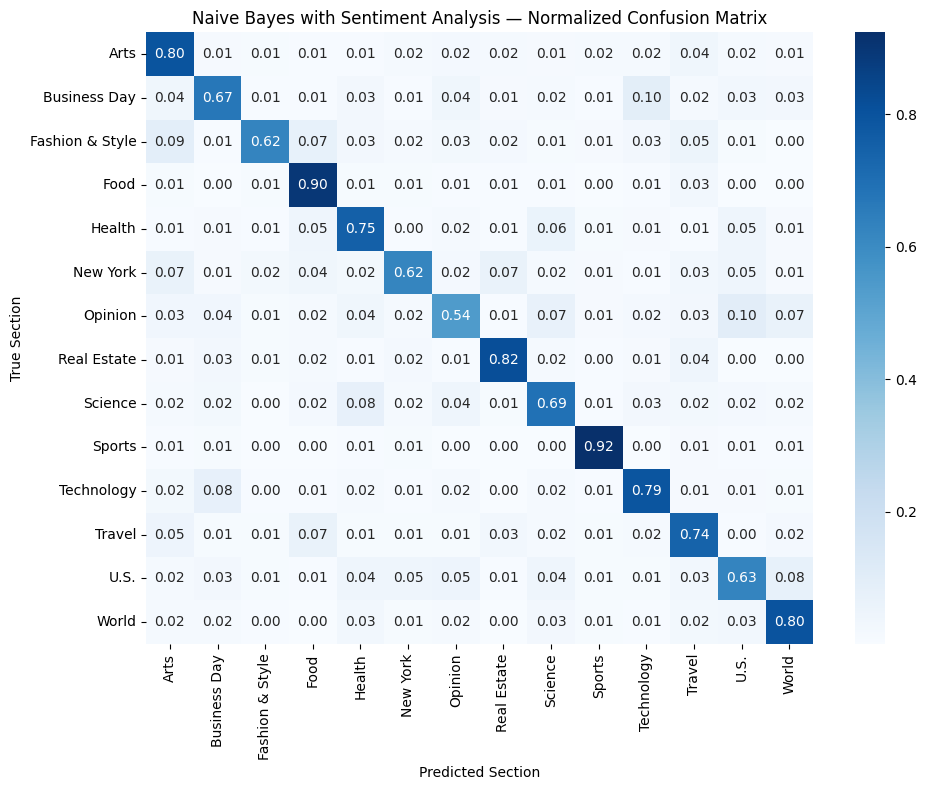

In [ ]:
text_col = "text_clean"
label_col = "label"
sent_cols = ["neg", "neu", "pos", "compound"]

# TF-IDF for text + scaled sentiment features
preproc_mm = ColumnTransformer(
    transformers=[
        ("tfidf", TfidfVectorizer(max_features=10_000, ngram_range=(1, 2)), text_col),
        ("vader", Pipeline([
            ("sel", FunctionTransformer(lambda df: df[sent_cols], validate=False)),
            ("scale", MinMaxScaler())
        ]), sent_cols)
    ],
    remainder="drop"
)

#preprocessing + MultinomialNB
nb_pipeline = Pipeline([
    ("prep", preproc_mm),
    ("clf", MultinomialNB())
])

# Fit on training + validation set
nb_pipeline.fit(trainval_df, y_train_val)

# Predict on train+val set
y_train_pred  = nb_pipeline.predict(trainval_df)
y_train_proba = nb_pipeline.predict_proba(trainval_df)

# Compute metrics
train_acc = accuracy_score(y_train_val, y_train_pred)
train_f1  = f1_score(y_train_val, y_train_pred, average='weighted')  # or 'macro'

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training F1-score: {train_f1:.4f}")


# Predict on test set
y_pred  = nb_pipeline.predict(test_df)
y_proba = nb_pipeline.predict_proba(test_df)

# Evaluate
evaluate_model(
    name   = "Naive Bayes with Sentiment Analysis",
    y_true = y_test,
    y_pred = y_pred,
    y_score= y_proba,
    label_encoder=label_encoder
)


## Basic Logistic Regression

Training Accuracy: 0.8380
Training F1-score: 0.8372

=== Performance Report: Basic Logistic Regression ===

                 precision    recall  f1-score   support

           Arts       0.75      0.79      0.77      1500
   Business Day       0.75      0.69      0.72      1500
Fashion & Style       0.83      0.74      0.79      1500
           Food       0.82      0.89      0.85      1500
         Health       0.75      0.77      0.76      1500
       New York       0.76      0.70      0.73      1500
        Opinion       0.67      0.65      0.66      1500
    Real Estate       0.84      0.85      0.85      1500
        Science       0.73      0.77      0.75      1500
         Sports       0.91      0.92      0.91      1500
     Technology       0.79      0.81      0.80      1500
         Travel       0.78      0.79      0.78      1500
           U.S.       0.72      0.69      0.70      1500
          World       0.80      0.82      0.81      1500

       accuracy                    

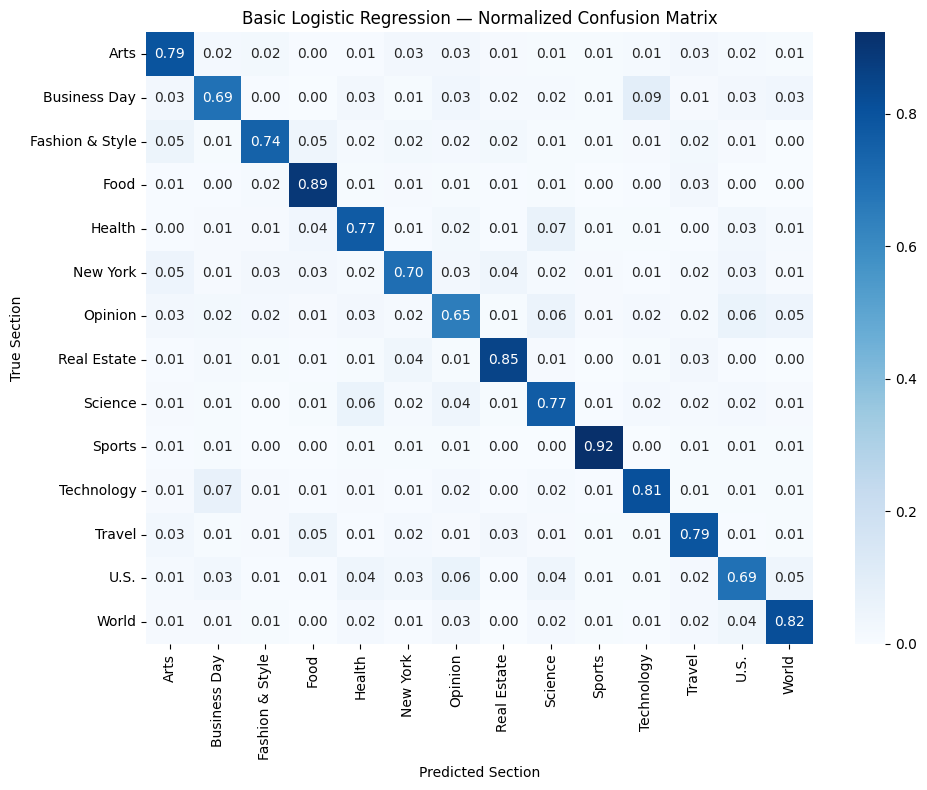

In [ ]:
lr_text_only = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10_000, ngram_range=(1, 2))),
    ("clf",   LogisticRegression(max_iter=1000, solver="saga", n_jobs=-1))
])

# Train on train+val set
lr_text_only.fit(trainval_df[text_col], y_train_val)

# Predict on training data
y_train_pred_lr  = lr_text_only.predict(trainval_df[text_col])
y_train_proba_lr = lr_text_only.predict_proba(trainval_df[text_col])

# Accuracy and F1
train_acc = accuracy_score(y_train_val, y_train_pred_lr)
train_f1  = f1_score(y_train_val, y_train_pred_lr, average='weighted')  # or 'macro'

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training F1-score: {train_f1:.4f}")


# Predict on test set
y_pred_lr   = lr_text_only.predict(test_df[text_col])
y_proba_lr  = lr_text_only.predict_proba(test_df[text_col])

# Evaluate
evaluate_model(
    name   = "Basic Logistic Regression",
    y_true = y_test,
    y_pred = y_pred_lr,
    y_score= y_proba_lr,
    label_encoder=label_encoder
)


##Logistic Regression with sentiment analyis

Training Accuracy: 0.8371
Training F1-score: 0.8364

=== Performance Report: Logistic Regression with Sentiment Analysis ===

                 precision    recall  f1-score   support

           Arts       0.76      0.79      0.77      1500
   Business Day       0.75      0.69      0.72      1500
Fashion & Style       0.83      0.75      0.79      1500
           Food       0.81      0.89      0.85      1500
         Health       0.75      0.77      0.76      1500
       New York       0.77      0.70      0.73      1500
        Opinion       0.67      0.65      0.66      1500
    Real Estate       0.84      0.86      0.85      1500
        Science       0.73      0.77      0.75      1500
         Sports       0.91      0.92      0.91      1500
     Technology       0.79      0.81      0.80      1500
         Travel       0.78      0.79      0.78      1500
           U.S.       0.72      0.69      0.70      1500
          World       0.79      0.82      0.80      1500

       accuracy  

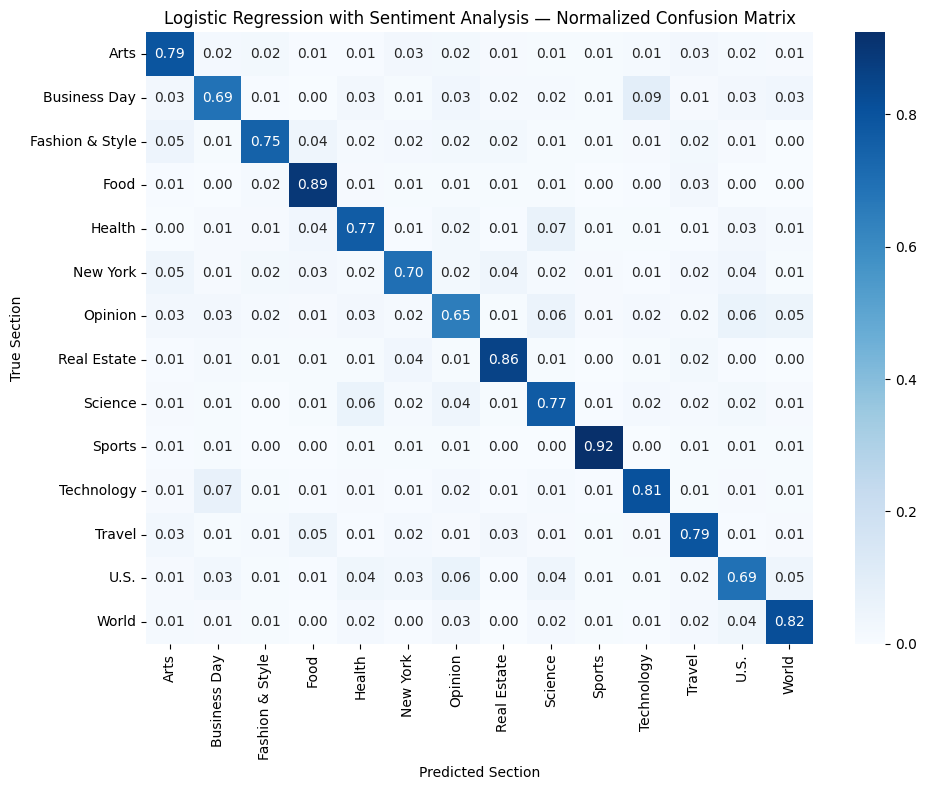

In [ ]:
preproc_lr = ColumnTransformer(
    transformers=[
        ("tfidf", TfidfVectorizer(max_features=10_000, ngram_range=(1, 2)), text_col),
        ("vader", Pipeline([
            ("sel", FunctionTransformer(lambda df: df[sent_cols], validate=False)),
            ("scale", MinMaxScaler())
        ]), sent_cols)
    ],
    remainder="drop"
)

# preprocessing + classifier
lr_sent_pipeline = Pipeline([
    ("prep", preproc_lr),
    ("clf",  LogisticRegression(max_iter=1000, solver="saga", n_jobs=-1))
])

# Train on train + val
lr_sent_pipeline.fit(trainval_df, y_train_val)

# Predict on training data
y_train_pred_lr_s  = lr_sent_pipeline.predict(trainval_df)
y_train_proba_lr_s = lr_sent_pipeline.predict_proba(trainval_df)

# Accuracy and F1-score
train_acc = accuracy_score(y_train_val, y_train_pred_lr_s)
train_f1  = f1_score(y_train_val, y_train_pred_lr_s, average='weighted')  # or 'macro'

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training F1-score: {train_f1:.4f}")


# Predict on test set
y_pred_lr_s  = lr_sent_pipeline.predict(test_df)
y_proba_lr_s = lr_sent_pipeline.predict_proba(test_df)

# Evaluate
evaluate_model(
    name   = "Logistic Regression with Sentiment Analysis",
    y_true = y_test,
    y_pred = y_pred_lr_s,
    y_score= y_proba_lr_s,
    label_encoder=label_encoder
)

## Basic MLP and MLP with sentiment analysis
Due to the use of different Numpy Libraries, the MLP models were extracted to a separate notebook. Test and Train split as well as evaluation was kept coherent to the other models.
https://github.com/Johlan200/NLP_Final/blob/1ea92b866193022f5924ef7949646ab15a603f4c/NLP_MLP_Models.ipynb

## Basic Hybrid model

Training Accuracy: 0.9234
Training F1-score: 0.9231

=== Performance Report: Stacked Ensemble (No Sentiment) ===

                 precision    recall  f1-score   support

           Arts       0.77      0.79      0.78      1500
   Business Day       0.74      0.70      0.72      1500
Fashion & Style       0.80      0.76      0.78      1500
           Food       0.85      0.88      0.87      1500
         Health       0.78      0.79      0.78      1500
       New York       0.76      0.72      0.74      1500
        Opinion       0.69      0.70      0.70      1500
    Real Estate       0.85      0.88      0.87      1500
        Science       0.76      0.78      0.77      1500
         Sports       0.91      0.92      0.91      1500
     Technology       0.80      0.81      0.81      1500
         Travel       0.79      0.83      0.81      1500
           U.S.       0.72      0.69      0.70      1500
          World       0.82      0.81      0.81      1500

       accuracy              

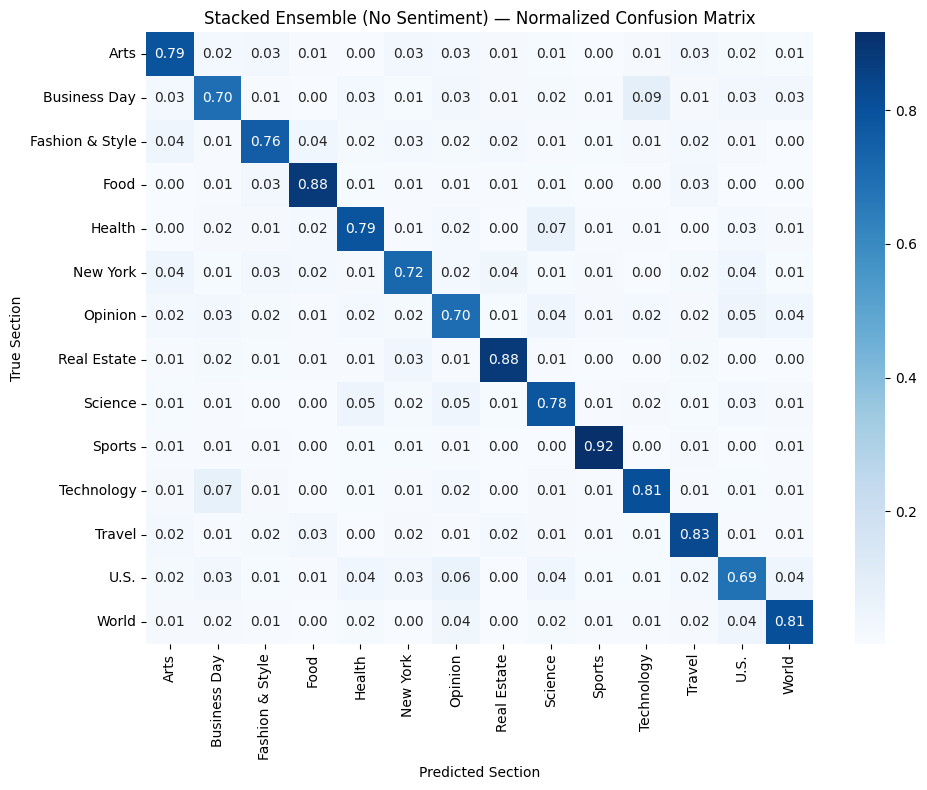

In [ ]:
text_col = "text_clean"
label_col = "label"

# Preprocessing: TF-IDF
preprocessor = ColumnTransformer([
    ("text", TfidfVectorizer(max_features=10_000, ngram_range=(1, 2)), text_col)
], remainder="drop")

# Base learners
nb_pipeline = Pipeline([("preproc", preprocessor), ("clf", MultinomialNB())])
lr_pipeline = Pipeline([("preproc", preprocessor), ("clf", LogisticRegression(max_iter=1000))])
mlp_pipeline = Pipeline([("preproc", preprocessor),
                         ("clf", MLPClassifier(hidden_layer_sizes=(100,), max_iter=200))])

estimators = [
    ('nb',  nb_pipeline),
    ('lr',  lr_pipeline),
    ('mlp', mlp_pipeline)
]

# Stacking classifier
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Fit model
stack.fit(trainval_df, y_train_val)

# Predict on training data
y_train_pred_stack  = stack.predict(trainval_df)
y_train_proba_stack = stack.predict_proba(trainval_df)

# Accuracy and F1
train_acc = accuracy_score(y_train_val, y_train_pred_stack)
train_f1  = f1_score(y_train_val, y_train_pred_stack, average='weighted')  # or 'macro'

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training F1-score: {train_f1:.4f}")


# Predict on test
y_pred_stack  = stack.predict(test_df)
y_proba_stack = stack.predict_proba(test_df)

# Evaluate
evaluate_model(
    name="Stacked Ensemble (No Sentiment)",
    y_true=y_test,
    y_pred=y_pred_stack,
    y_score=y_proba_stack,
    label_encoder=label_encoder
)


## Hybrid model with sentiment analysis

Training Accuracy: 0.9197
Training F1-score: 0.9193

=== Performance Report: Stacked Ensemble (Train+Val → Test) ===

                 precision    recall  f1-score   support

           Arts       0.78      0.79      0.78      1500
   Business Day       0.75      0.70      0.72      1500
Fashion & Style       0.79      0.77      0.78      1500
           Food       0.84      0.88      0.86      1500
         Health       0.78      0.79      0.79      1500
       New York       0.76      0.73      0.74      1500
        Opinion       0.70      0.70      0.70      1500
    Real Estate       0.86      0.87      0.87      1500
        Science       0.77      0.79      0.78      1500
         Sports       0.92      0.91      0.91      1500
     Technology       0.80      0.83      0.81      1500
         Travel       0.79      0.83      0.81      1500
           U.S.       0.72      0.70      0.71      1500
          World       0.81      0.81      0.81      1500

       accuracy          

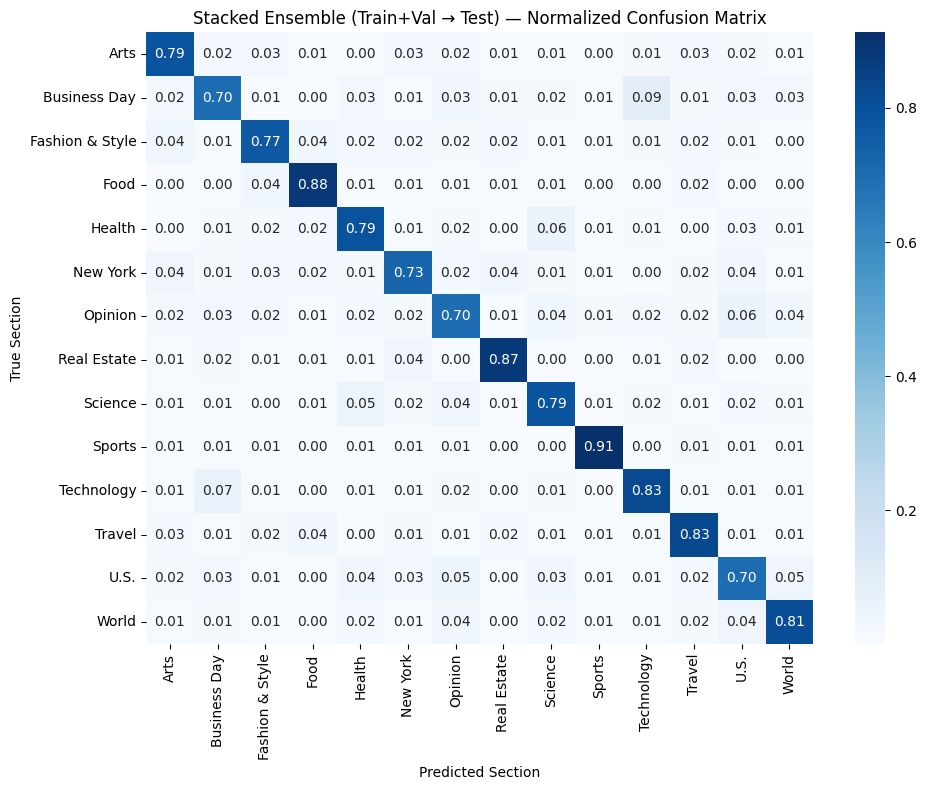

In [ ]:
text_col = "text_clean"
sent_cols = ["neg", "neu", "pos", "compound"]
label_col = "label"

# Preprocessing: TF-IDF + MinMax scaling on sentiment
preprocessor = ColumnTransformer([
    ("text", TfidfVectorizer(max_features=10_000, ngram_range=(1, 2)), text_col),
    ("vader", Pipeline([
        ("extract", FunctionTransformer(lambda df: df[sent_cols], validate=False)),
        ("scale", MinMaxScaler())
    ]), sent_cols)
], remainder="drop")

# Base learners
nb_pipeline = Pipeline([("preproc", preprocessor), ("clf", MultinomialNB())])
lr_pipeline = Pipeline([("preproc", preprocessor), ("clf", LogisticRegression(max_iter=1000))])
mlp_pipeline = Pipeline([("preproc", preprocessor),
                         ("clf", MLPClassifier(hidden_layer_sizes=(100,), max_iter=200))])

estimators = [
    ('nb',  nb_pipeline),
    ('lr',  lr_pipeline),
    ('mlp', mlp_pipeline)
]

# Stacking classifier
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Fit model
stack.fit(trainval_df, y_train_val)

# Predict on train+val set
y_train_pred_stack  = stack.predict(trainval_df)
y_train_proba_stack = stack.predict_proba(trainval_df)

# Accuracy and F1-score
train_acc = accuracy_score(y_train_val, y_train_pred_stack)
train_f1  = f1_score(y_train_val, y_train_pred_stack, average='weighted')

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training F1-score: {train_f1:.4f}")

# Predict on test
y_pred_stack  = stack.predict(test_df)
y_proba_stack = stack.predict_proba(test_df)

# Evaluate
evaluate_model(
    name="Stacked Ensemble (Train+Val → Test)",
    y_true=y_test,
    y_pred=y_pred_stack,
    y_score=y_proba_stack,
    label_encoder=label_encoder
)


## Bert

In [ ]:
from transformers import BertTokenizer, DataCollatorWithPadding
from datasets import Dataset
from torch.optim import AdamW
from tqdm import tqdm



# Load tokenizer and collator
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
collator = DataCollatorWithPadding(tokenizer)


In [ ]:
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df["label"] = y_train.values
val_df["label"] = y_val.values
test_df["label"] = y_test.values


In [ ]:
TEXT_COL, LABEL_COL = "text_raw", "label"
NUM_LABELS = train_df[LABEL_COL].nunique()


train_df[LABEL_COL] = train_df[LABEL_COL].astype("int64")
val_df[LABEL_COL]   = val_df[LABEL_COL].astype("int64")
test_df[LABEL_COL]  = test_df[LABEL_COL].astype("int64")  # Only if labels exist

# Load tokenizer and collator
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
collator = DataCollatorWithPadding(tokenizer)

# Tokenization function
def tok(batch):
    enc = tokenizer(batch[TEXT_COL],
                    truncation=True,
                    padding="max_length",
                    max_length=256)
    enc["labels"] = batch[LABEL_COL]
    return enc

# Train
train_ds = Dataset.from_pandas(train_df)
train_ds = train_ds.map(tok, batched=True)
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Val
val_ds = Dataset.from_pandas(val_df)
val_ds = val_ds.map(tok, batched=True)
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Test
test_ds = Dataset.from_pandas(test_df)
test_ds = test_ds.map(tok, batched=True)
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/98000 [00:00<?, ? examples/s]

Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=NUM_LABELS
)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

#DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collator)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, collate_fn=collator)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, collate_fn=collator)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}")

    # Validation
    model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            val_preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            val_labels.extend(batch["labels"].cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    print(f"Epoch {epoch+1} | Validation Accuracy: {val_acc:.4f}")

#Final Evaluation on Test Set
model.eval()
test_preds, test_labels, test_scores = [], [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits

        probs = softmax(logits, dim=-1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        test_preds.extend(preds)
        test_scores.extend(probs)
        test_labels.extend(batch["labels"].cpu().numpy())


evaluate_model(
    name="BERT Sequence Classification — Test Set",
    y_true=test_labels,
    y_pred=test_preds,
    y_score=test_scores,
    label_encoder=label_encoder)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[Epoch 1] Training: 100%|██████████| 12250/12250 [17:27<00:00, 11.70it/s]


Epoch 1 | Train Loss: 7822.1132
Epoch 1 | Validation Accuracy: 0.8510


[Epoch 2] Training: 100%|██████████| 12250/12250 [17:31<00:00, 11.65it/s]


Epoch 2 | Train Loss: 4089.8506
Epoch 2 | Validation Accuracy: 0.8642


[Epoch 3] Training: 100%|██████████| 12250/12250 [17:37<00:00, 11.58it/s]


Epoch 3 | Train Loss: 2391.2010
Epoch 3 | Validation Accuracy: 0.8741


Testing:   0%|          | 0/2625 [00:00<?, ?it/s]


TypeError: softmax() got an unexpected keyword argument 'dim'


=== Performance Report: BERT Sequence Classification — Test Set ===

                 precision    recall  f1-score   support

           Arts       0.87      0.83      0.85      1500
   Business Day       0.72      0.82      0.77      1500
Fashion & Style       0.89      0.78      0.83      1500
           Food       0.91      0.91      0.91      1500
         Health       0.82      0.87      0.84      1500
       New York       0.84      0.86      0.85      1500
        Opinion       0.83      0.87      0.85      1500
    Real Estate       0.90      0.94      0.92      1500
        Science       0.87      0.82      0.85      1500
         Sports       0.95      0.96      0.95      1500
     Technology       0.88      0.87      0.88      1500
         Travel       0.91      0.90      0.90      1500
           U.S.       0.80      0.79      0.79      1500
          World       0.89      0.86      0.88      1500

       accuracy                           0.86     21000
      macro avg 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


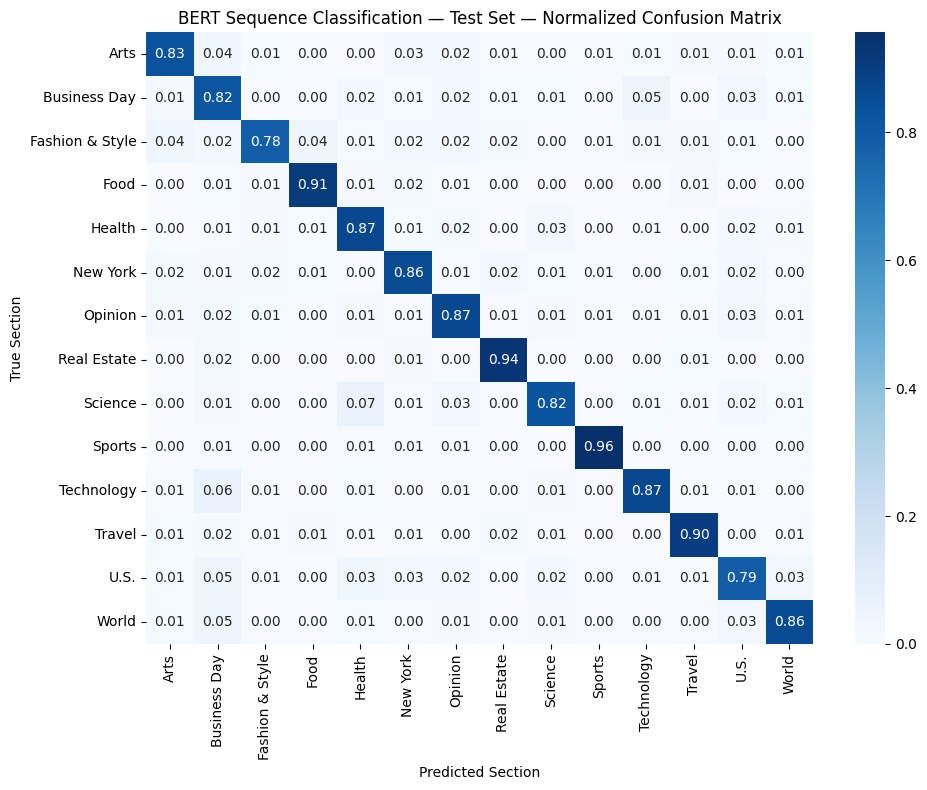

In [ ]:

evaluate_model(
    name="BERT Sequence Classification — Test Set",
    y_true=test_labels,
    y_pred=test_preds,
    y_score=test_scores,
    label_encoder=label_encoder)



## Bert with sentiment analysis

In [ ]:
def train_model(model, train_loader, val_loader, device, epochs=3, lr=2e-5):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for i, batch in enumerate(pbar):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            out = model(**batch)
            logits = out['logits']

            tqdm.write(f"Logits shape: {logits.shape}")

            out["loss"].backward()
            optimizer.step()
            total_loss += out["loss"].item()

            pbar.set_postfix(train_loss=total_loss / (i + 1), refresh=False)

        evaluate(model, val_loader, device, "Validation")


def evaluate(model, loader, device, name="Test"):
    model.eval()
    preds, labels, probs = [], [], []

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)
            logits = out["logits"]
            print(f"Logits shape in evaluate: {logits.shape}")
            probs_batch = softmax(logits, dim=1).cpu().numpy()
            preds_batch = np.argmax(probs_batch, axis=1)

            preds.extend(preds_batch)
            probs.extend(probs_batch)
            labels.extend(batch["labels"].cpu().numpy())

    evaluate_model(
        name=f"BERT + Sentiment — {name} Set",
        y_true=labels,
        y_pred=preds,
        y_score=probs,
        label_encoder=label_encoder
    )


In [ ]:
TEXT_COL = "text_raw"
LABEL_COL = "label"
SENT_COLS = ["neg", "neu", "pos", "compound"]
NUM_LABELS = train_df[LABEL_COL].nunique()

#Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
collator = DataCollatorWithPadding(tokenizer)

def tok(batch):

    enc = tokenizer(batch[TEXT_COL],
                    truncation=True,
                    padding="max_length",
                    max_length=256)

    enc["labels"] = batch[LABEL_COL]

    enc["sent_feats"] = [
        [neg, neu, pos, comp]
        for neg, neu, pos, comp in zip(*(batch[c] for c in SENT_COLS))
    ]
    return enc

train_ds = Dataset.from_pandas(train_df)
train_ds = train_ds.map(tok, batched=True, remove_columns=train_ds.column_names)
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sent_feats"])

val_ds   = Dataset.from_pandas(val_df)
val_ds   = val_ds.map(tok, batched=True, remove_columns=val_ds.column_names)
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sent_feats"])

test_ds  = Dataset.from_pandas(test_df)
test_ds  = test_ds.map(tok, batched=True, remove_columns=test_ds.column_names)
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sent_feats"])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=8)
test_loader  = DataLoader(test_ds,  batch_size=8)

Map:   0%|          | 0/98000 [00:00<?, ? examples/s]

Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 [Train]:   0%|          | 0/12250 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/2625 [00:00<?, ?it/s]

Epoch 1 | Validation Accuracy: 0.8439
----------------------------------------


Epoch 2 [Train]:   0%|          | 0/12250 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/2625 [00:00<?, ?it/s]

Epoch 2 | Validation Accuracy: 0.8698
----------------------------------------


Epoch 3 [Train]:   0%|          | 0/12250 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/2625 [00:00<?, ?it/s]

Epoch 3 | Validation Accuracy: 0.8687
----------------------------------------


Testing:   0%|          | 0/2625 [00:00<?, ?it/s]


=== Performance Report: BERT + Sentiment — Test Set ===

                 precision    recall  f1-score   support

           Arts       0.88      0.85      0.87      1500
   Business Day       0.79      0.79      0.79      1500
Fashion & Style       0.93      0.78      0.85      1500
           Food       0.91      0.91      0.91      1500
         Health       0.84      0.84      0.84      1500
       New York       0.82      0.86      0.84      1500
        Opinion       0.91      0.77      0.84      1500
    Real Estate       0.88      0.94      0.91      1500
        Science       0.86      0.83      0.85      1500
         Sports       0.93      0.98      0.95      1500
     Technology       0.81      0.90      0.86      1500
         Travel       0.87      0.93      0.90      1500
           U.S.       0.79      0.83      0.81      1500
          World       0.89      0.87      0.88      1500

       accuracy                           0.86     21000
      macro avg       0.87  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


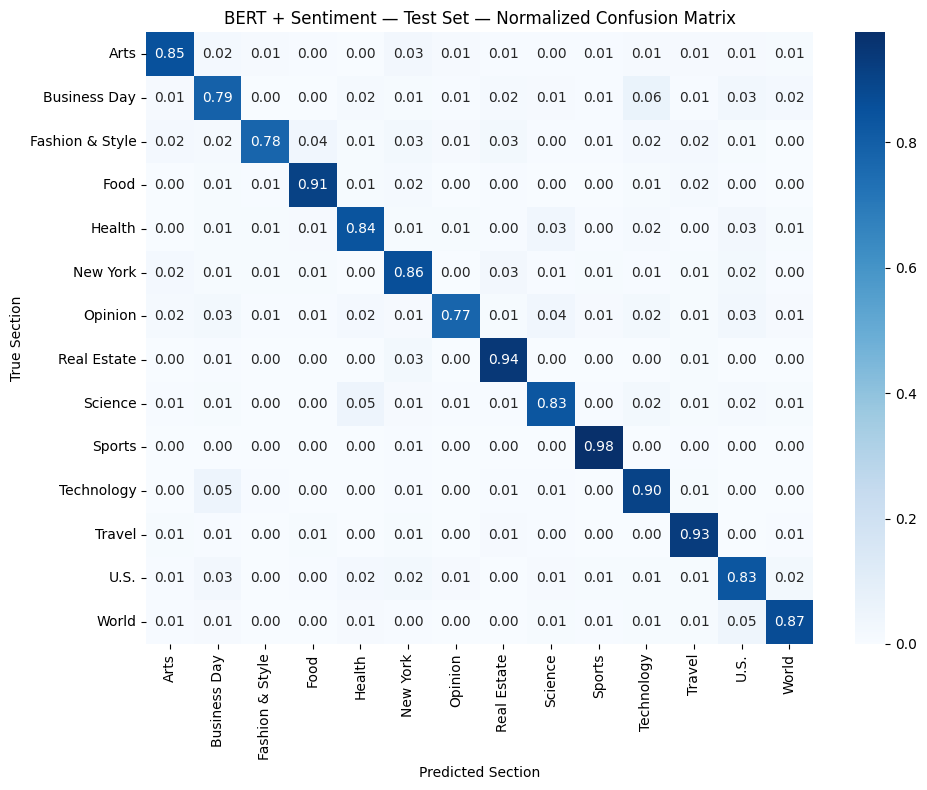

In [ ]:
#Model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=NUM_LABELS
)
# replace the classifier so we can inject sentiment features
class BertWithSentiment(nn.Module):
    def __init__(self, hf_model, num_sent_feats, dropout=0.1):
        super().__init__()
        self.bert = hf_model.bert
        hs = self.bert.config.hidden_size
        self.sent_fc    = nn.Linear(num_sent_feats, hs // 4)
        self.dropout    = nn.Dropout(dropout)
        self.classifier = nn.Linear(hs + hs//4, NUM_LABELS)

    def forward(self, input_ids, attention_mask, sent_feats, labels=None):
        out    = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = out.pooler_output
        sent_h = F.relu(self.sent_fc(sent_feats))
        x      = torch.cat([pooled, sent_h], dim=1)
        x      = self.dropout(x)
        logits = self.classifier(x)
        loss   = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
        return {"loss":loss, "logits":logits}


model = BertWithSentiment(model, num_sent_feats=4).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

#Optimizer
optim = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

#Training + Validation with tqdm
for epoch in range(1, 4):
    model.train()
    train_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
    for i, batch in enumerate(pbar):
        batch = {k:v.to(model.classifier.weight.device) for k,v in batch.items()}
        out   = model(**batch)
        out["loss"].backward()
        optim.step()
        optim.zero_grad()
        train_loss += out["loss"].item()
        pbar.set_postfix(train_loss=train_loss/(i+1), refresh=False)

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]")
    with torch.no_grad():
        for batch in pbar:
            batch = {k:v.to(model.classifier.weight.device) for k,v in batch.items()}
            logits = model(**batch)["logits"]
            preds  = logits.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch["labels"].cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch} | Validation Accuracy: {acc:.4f}\n" + "-"*40)

#Final Test Eval
model.eval()
test_preds, test_labels, test_scores = [], [], []
pbar = tqdm(test_loader, desc="Testing")
with torch.no_grad():
    for batch in pbar:
        batch  = {k:v.to(model.classifier.weight.device) for k,v in batch.items()}
        logits = model(**batch)["logits"]
        probs  = softmax(logits.cpu().numpy(), axis=1)
        preds  = np.argmax(probs, axis=1)
        test_preds.extend(preds)
        test_scores.extend(probs)
        test_labels.extend(batch["labels"].cpu().numpy())

evaluate_model(
    name="BERT + Sentiment — Test Set",
    y_true=test_labels,
    y_pred=test_preds,
    y_score=test_scores,
    label_encoder=label_encoder
)
